In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [247]:
sADF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site A - Tue Feb 15 2022 to Thu Jun 30 2022.csv")
sBDF=pd.read_csv(r"C:\Users\Hasib\OneDrive - University of Calgary\PIMS M2PI Workshop 2022\Novion GI\Site B - Tue Feb 15 2022 to Thu Jun 30 2022.csv")

In [248]:
sADF.head()

,Timestamp,Water Level [m]
0,2022-02-15 5:05:00 p.m.,0.238
1,2022-02-15 5:10:00 p.m.,0.237
2,2022-02-15 5:15:00 p.m.,0.236
3,2022-02-15 5:20:00 p.m.,0.235
4,2022-02-15 5:25:00 p.m.,0.234


In [249]:
sBDF.head()

,Timestamp,Water Level [m]
0,2022-02-15 5:00:00 p.m.,0.003
1,2022-02-15 5:05:00 p.m.,0.003
2,2022-02-15 5:10:00 p.m.,0.003
3,2022-02-15 5:15:00 p.m.,0.003
4,2022-02-15 5:20:00 p.m.,0.003


In [250]:
print(sADF.shape,sBDF.shape)

(38951, 2) (38952, 2)


In [251]:
print(sADF.columns,sBDF.columns)

Index(['Timestamp', ' Water Level [m]'], dtype='object') Index(['Timestamp', ' Water Level [m]'], dtype='object')


In [252]:
sADF[" Water Level [m]"].describe()

count    38951.000000
mean         0.375446
std          0.226902
min          0.016000
25%          0.249500
50%          0.299000
75%          0.472000
max          1.428000
Name:  Water Level [m], dtype: float64

In [253]:
sBDF[" Water Level [m]"].describe()

count    38952.000000
mean         0.035009
std          0.031732
min         -0.017000
25%          0.003000
50%          0.034000
75%          0.061000
max          0.253000
Name:  Water Level [m], dtype: float64

In [254]:
pd.to_datetime(sADF["Timestamp"]);
pd.to_datetime(sBDF["Timestamp"]);

In [255]:
wl_mm=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm
slope_up=[]
slope_dw=[]
for i in range(sADF.shape[0]-4):
    slope_dw.append((wl_mm[i+4]-wl_mm[i])/4*5)
    slope_up.append((wl_mm[i+1]-wl_mm[i])/5)
#plt.plot(slope_1)
#plt.plot(wl_mm)

(array([1.4000e+01, 5.8000e+01, 6.8900e+02, 3.7641e+04, 3.6400e+02,
        1.1800e+02, 2.7000e+01, 1.2000e+01, 1.4000e+01, 1.0000e+01]),
 array([-666.25, -469.  , -271.75,  -74.5 ,  122.75,  320.  ,  517.25,
         714.5 ,  911.75, 1109.  , 1306.25]),
 <a list of 10 Patch objects>)

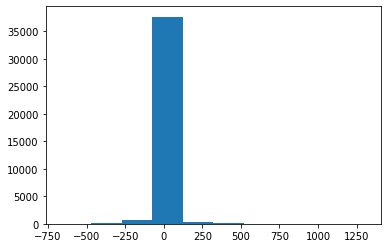

In [256]:
plt.hist(slope_dw)

(array([5.0000e+00, 4.9000e+01, 3.8724e+04, 1.4400e+02, 1.6000e+01,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-64.8, -38.7, -12.6,  13.5,  39.6,  65.7,  91.8, 117.9, 144. ,
        170.1, 196.2]),
 <a list of 10 Patch objects>)

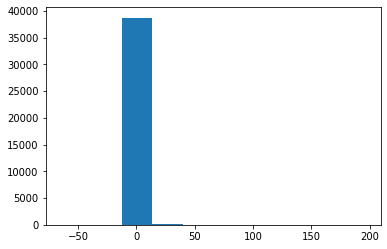

In [258]:
plt.hist(slope_up)

In [263]:
def IdentifyEvents_2(df,tol_up,tol_dw):
    #  2nd try
    wlc_mm=np.diff(df[" Water Level [m]"])*1000 # water level change measured in mm
    wl_mm=df[" Water Level [m]"].to_numpy()*1000  # water level in mm
    nre=True
    # rpc=0
    dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    duration=[]
    for i in range (df.shape[0]-3):
        
        if nre==True:
            rpc=0    # duration of rainfall set to zero
            # calculating the slope (mm/min) at index i+1
            #slope_1=(wl_mm[i]-wl_mm[i+2])/2*5
            slope_1=(wl_mm[i+1]-wl_mm[i])/2*5
            if slope_1>tol_up:
                # This is a new rainfall event
                # print("A new rainfall started at time :",df["Timestamp"][i]," with index position :",i)
                start_time.append(df["Timestamp"][i])
                start_index.append(i)
                dpc=0     # Dry period count initialization
                rpc+=1      # count the duration of rainfall
                nre=False
                # continue
        else:
            # calculating the slope (mm/min) at index i+1
            # slope_2=(wl_mm[i-1]-8*wl_mm[i]+8*wl_mm[i+2]-wl_mm[i+3])/12*5
            slope_2=(wl_mm[i+4]-wl_mm[i])/4*5
            if slope_2>tol_dw: 
                dpc+=1
                skip=2*(5*12)    # 6 hours of no significant change in water level means start of another event
                # save this date 
                if dpc>skip:
                    nre=True
                    end_time.append(df["Timestamp"][i+1-skip])
                    end_index.append(i+1-skip)
                    duration.append(rpc-skip)
                    #print(f"Rainfall event ended at time :",df["Timestamp"][i-72]," with index position :",i-72,"\nDuration of this rainfall period was :",rpc-72)
                    #print("Now it is a dry period of more than 6 hours")
                    #print("***********************************" )
                    # continue
                else:
                    rpc+=1    # count the duration of rainfall
            else:
                dpc=0
                rpc+=1
    return start_time,end_time,start_index,end_index,duration,wlc_mm

In [264]:
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA,water_level_changeA=IdentifyEvents_2(sADF,100,-5)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA
#np.size(start_timeA)

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:30:00 a.m.,2022-02-20 12:45:00 a.m.,1085,1244,158
1,2022-02-21 3:55:00 a.m.,2022-02-21 9:35:00 a.m.,1570,1638,67
2,2022-02-26 5:25:00 p.m.,2022-03-01 5:20:00 a.m.,3172,3891,718
3,2022-03-01 4:25:00 p.m.,2022-03-03 1:00:00 p.m.,4024,4559,534
4,2022-03-11 8:55:00 p.m.,2022-03-16 3:35:00 a.m.,6958,8178,1219
5,2022-03-17 7:00:00 a.m.,2022-03-19 8:20:00 p.m.,8507,9243,735
6,2022-03-20 2:20:00 p.m.,2022-03-24 4:35:00 p.m.,9459,10638,1178
7,2022-03-26 5:05:00 a.m.,2022-03-26 3:25:00 p.m.,11076,11200,123
8,2022-03-29 10:35:00 p.m.,2022-03-30 3:35:00 a.m.,12150,12210,59
9,2022-04-03 5:15:00 a.m.,2022-04-04 7:05:00 a.m.,13382,13692,309


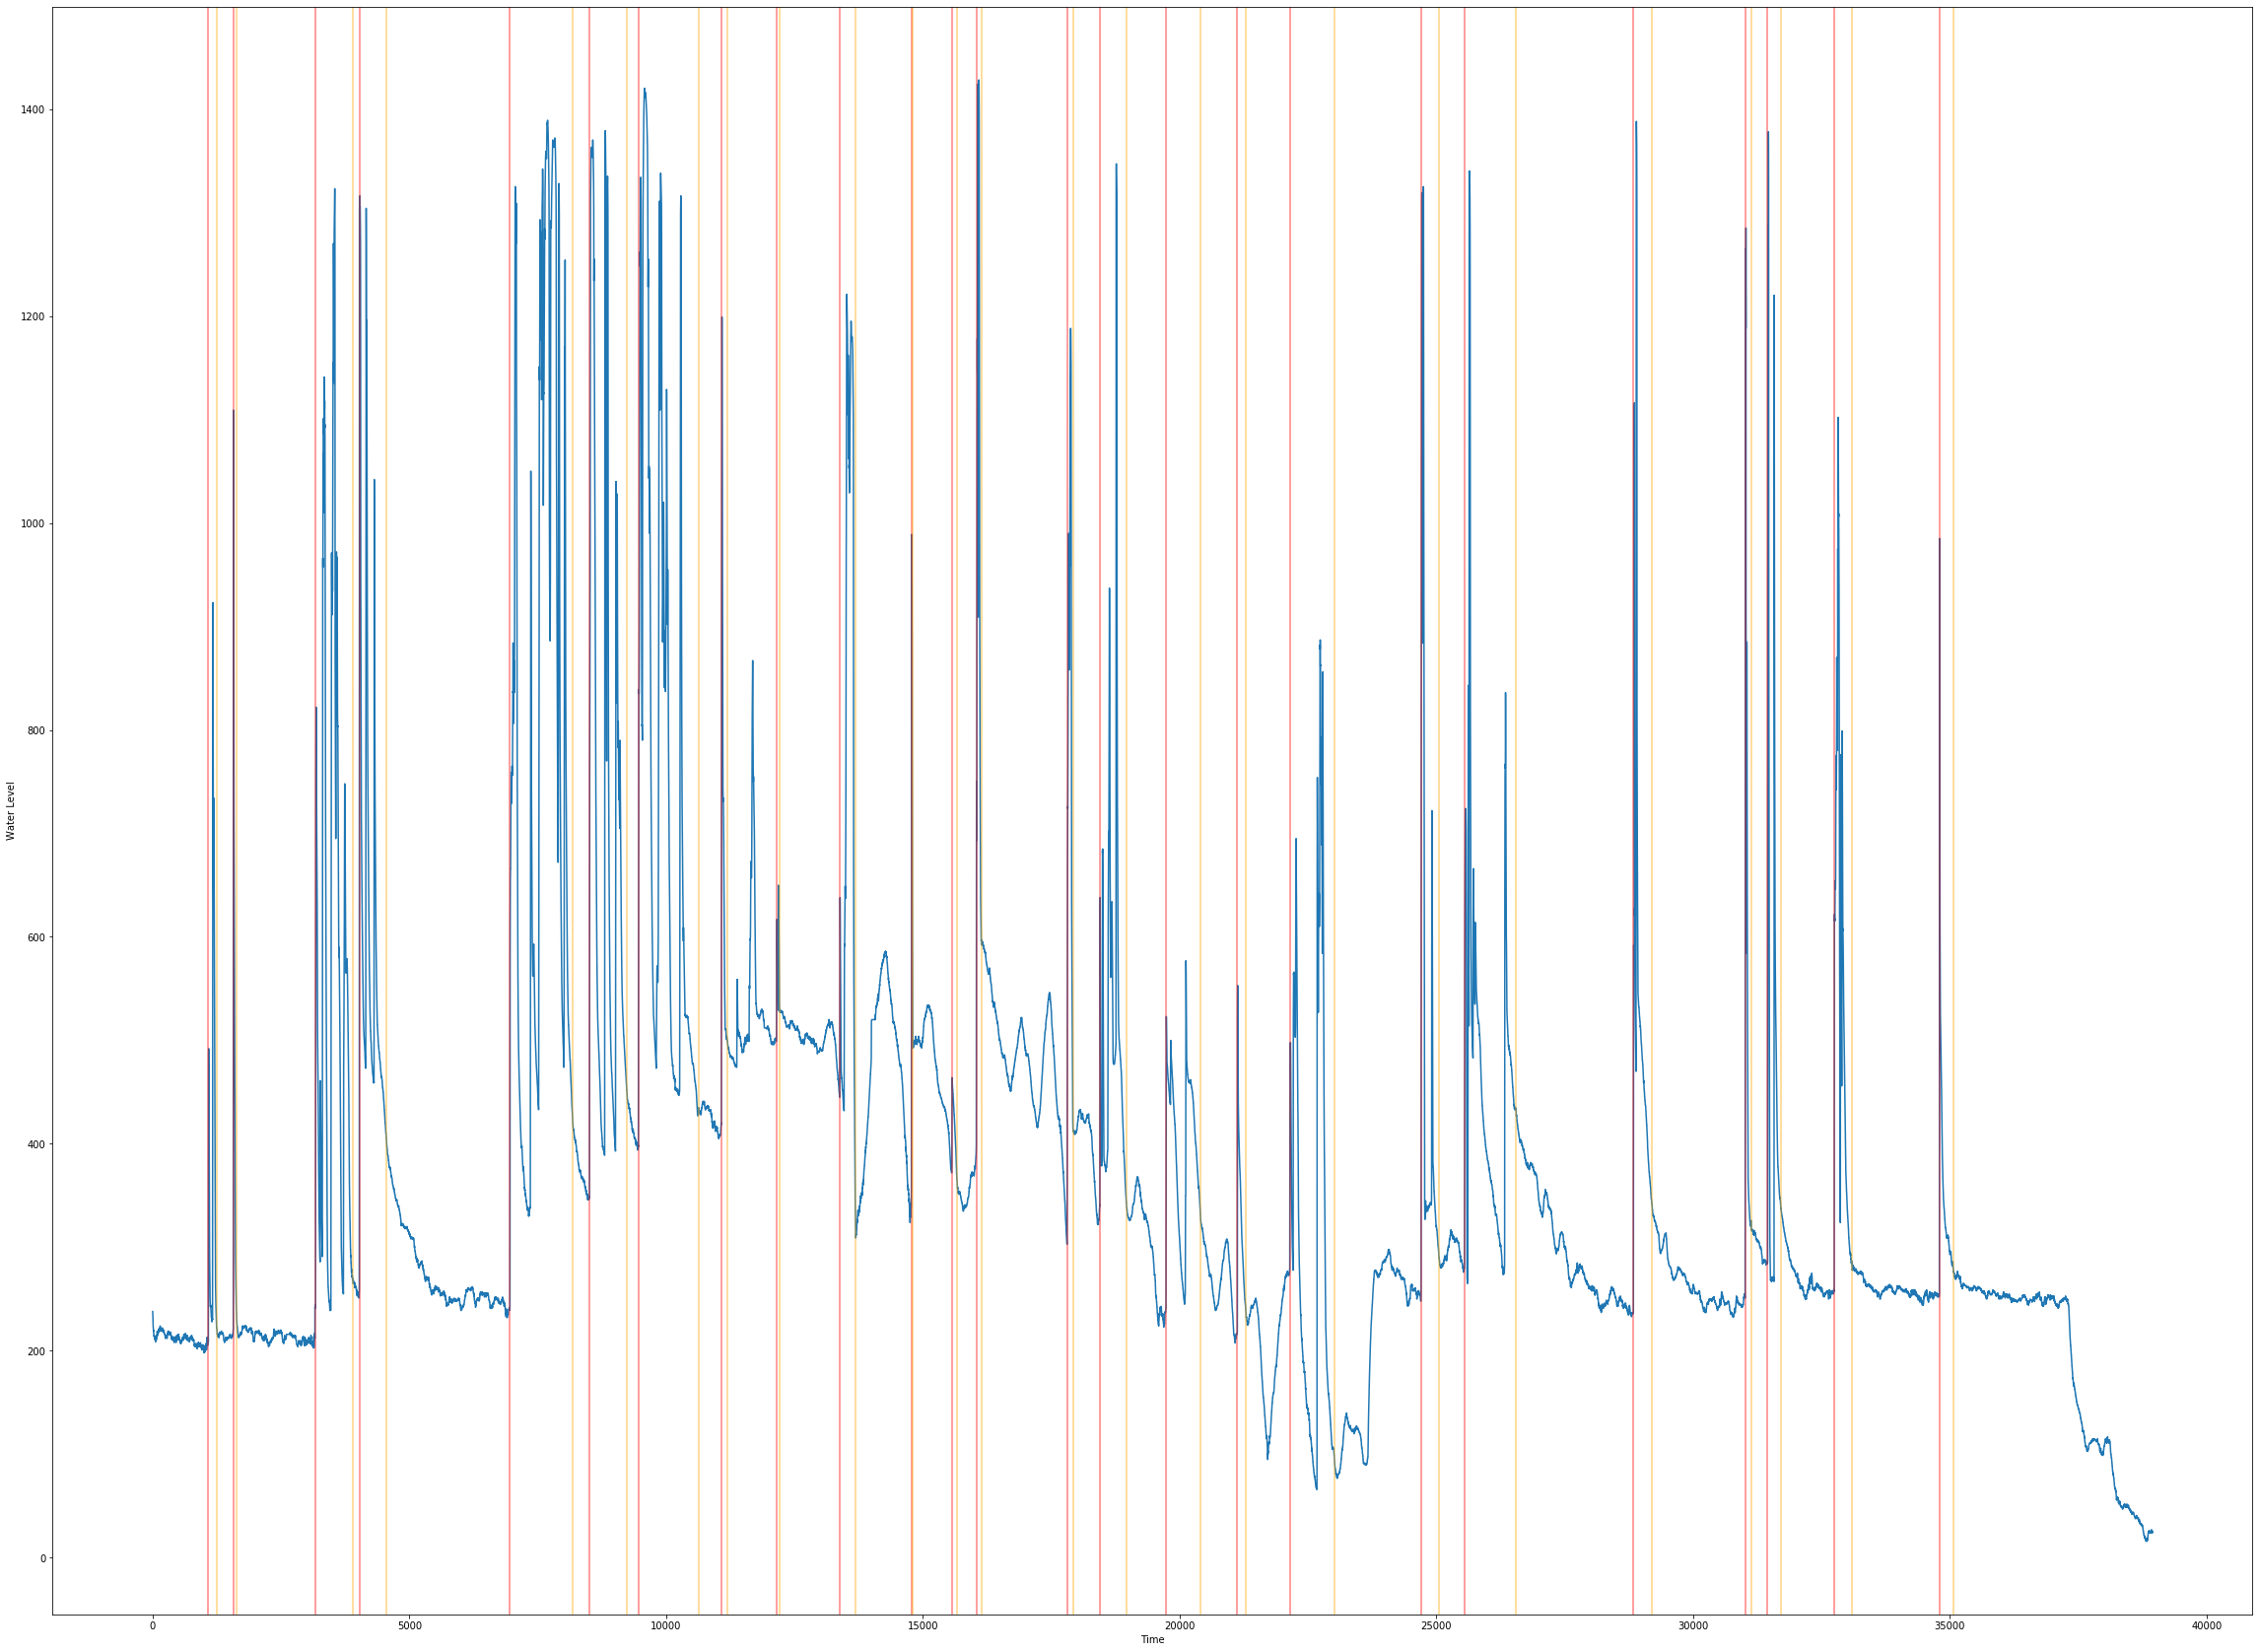

In [265]:
water_level=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm
plt.figure(figsize=(40, 30))
plt.plot(water_level)
for i in start_indexA:
    plt.axvline(x=i, alpha=0.5,color='r')
for i in end_indexA:
    plt.axvline(x=i,alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.show()

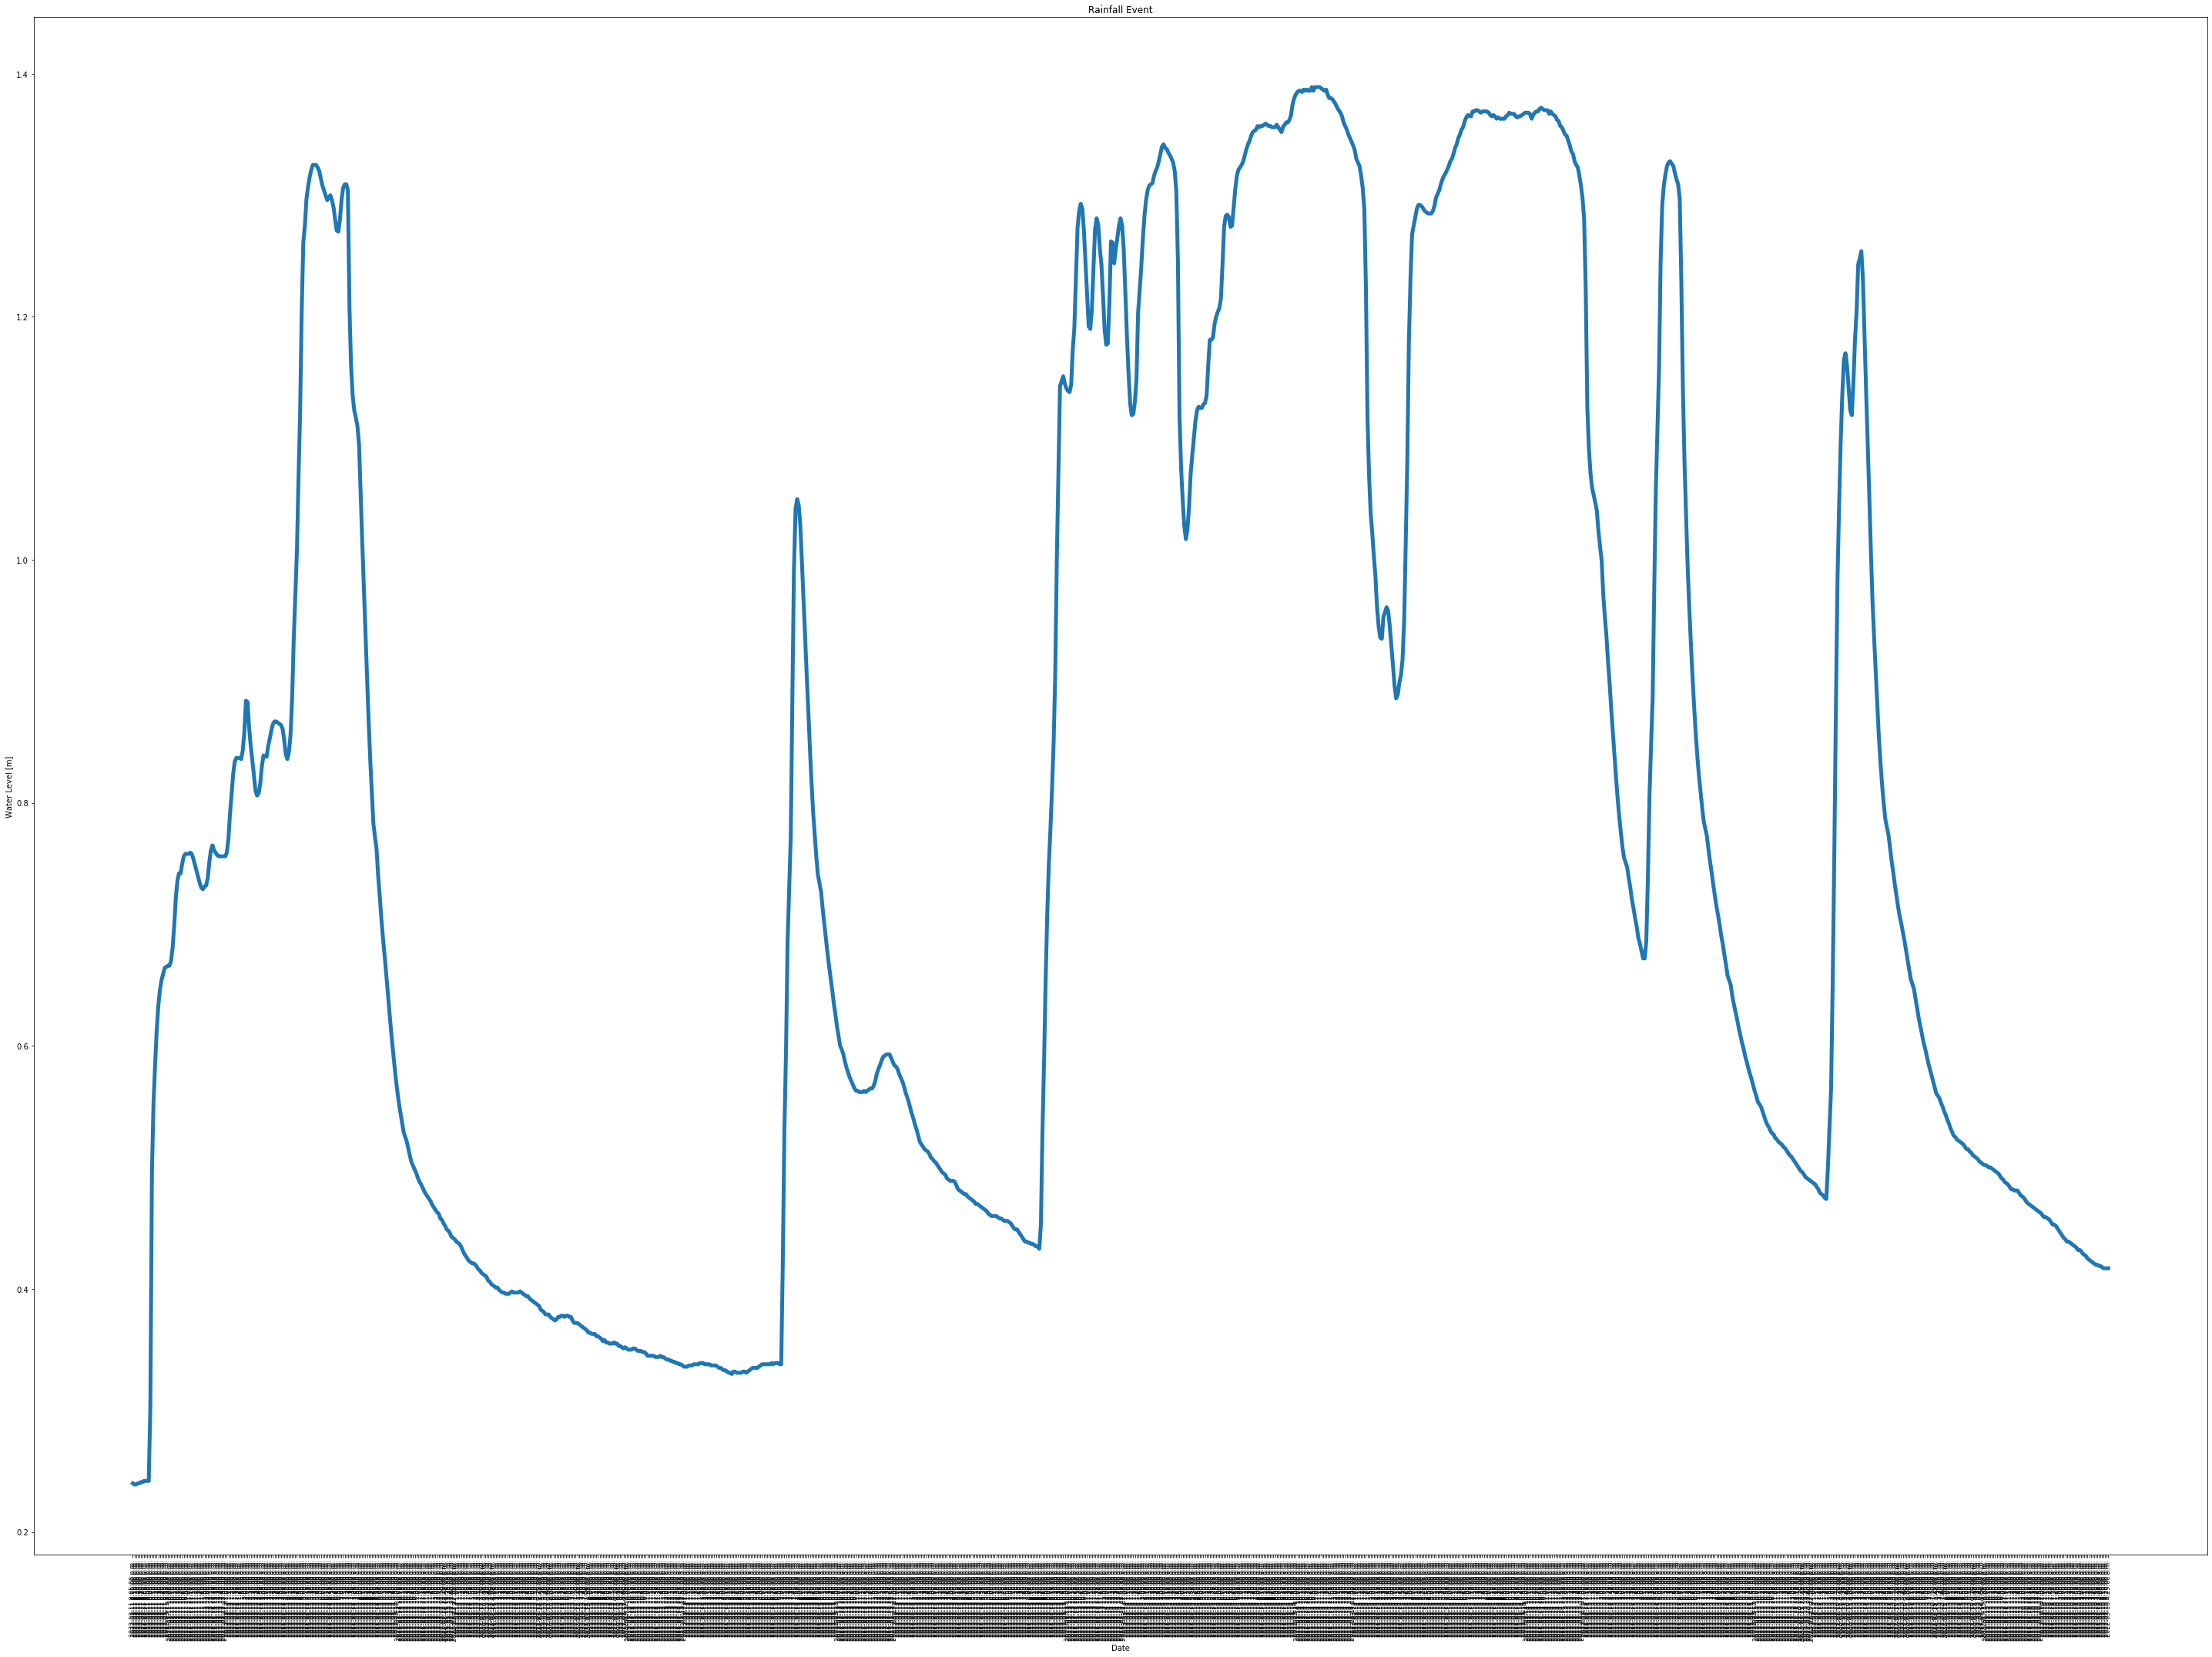

In [266]:
# Rainfall event
buffer=10
index=4
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
#plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
tolB=sBDF[" Water Level [m]"].mean()-sBDF[" Water Level [m]"].std()
tolA=sADF[" Water Level [m]"].mean()-1*sADF[" Water Level [m]"].std()

In [12]:
print(sADF[" Water Level [m]"].mean(),sBDF[" Water Level [m]"].mean())
print(sADF[" Water Level [m]"].min(),sBDF[" Water Level [m]"].min())
print(tolA,tolB)

0.3754458678853016 0.03500908810843181
0.016 -0.017
0.14854367185675632 0.0032766881418301377


In [14]:
def IdentifyRainfall(df,tol):
    nre=True
    # rpc=0
    dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    duration=[]
    for i in range (df.shape[0]):
        if nre==True:
            rpc=0    # duration of rainfall set to zero
            if df[" Water Level [m]"][i]>tol:
                # This is a new rainfall event
                #print("A new rainfall started at time :",df["Timestamp"][i]," with index position :",i)
                start_time.append(df["Timestamp"][i])
                start_index.append(i)
                dpc=0     # Dry period count initialization
                rpc+=1      # count the duration of rainfall
                nre=False
                # continue
        else:
            if df[" Water Level [m]"][i]<tol: 
                dpc+=1
                # save this date 
                if dpc>72:
                    nre=True
                    end_time.append(df["Timestamp"][i-72])
                    end_index.append(i-72)
                    duration.append(rpc-72)
                    #print(f"Rainfall event ended at time :",df["Timestamp"][i-72]," with index position :",i-72,"\nDuration of this rainfall period was :",rpc-72)
                    #print("Now it is a dry period of more than 6 hours")
                    #print("***********************************" )
                    # continue
                else:
                    rpc+=1    # count the duration of rainfall
            else:
                dpc=0
                rpc+=1
    return start_time,end_time,start_index,end_index,duration

In [15]:
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA=IdentifyRainfall(sADF,tolA)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-15 5:05:00 p.m.,2022-05-01 9:55:00 p.m.,0,21646,21646
1,2022-05-02 11:00:00 a.m.,2022-05-04 7:00:00 p.m.,21803,22475,672
2,2022-05-05 11:55:00 a.m.,2022-05-06 7:55:00 a.m.,22678,22918,240
3,2022-05-09 12:00:00 a.m.,2022-06-25 9:30:00 p.m.,23687,37481,13794


In [39]:
buffer=6
index=1
sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"].describe()

count    685.000000
mean       0.284029
std        0.128603
min        0.145000
25%        0.192000
50%        0.250000
75%        0.292000
max        0.695000
Name:  Water Level [m], dtype: float64

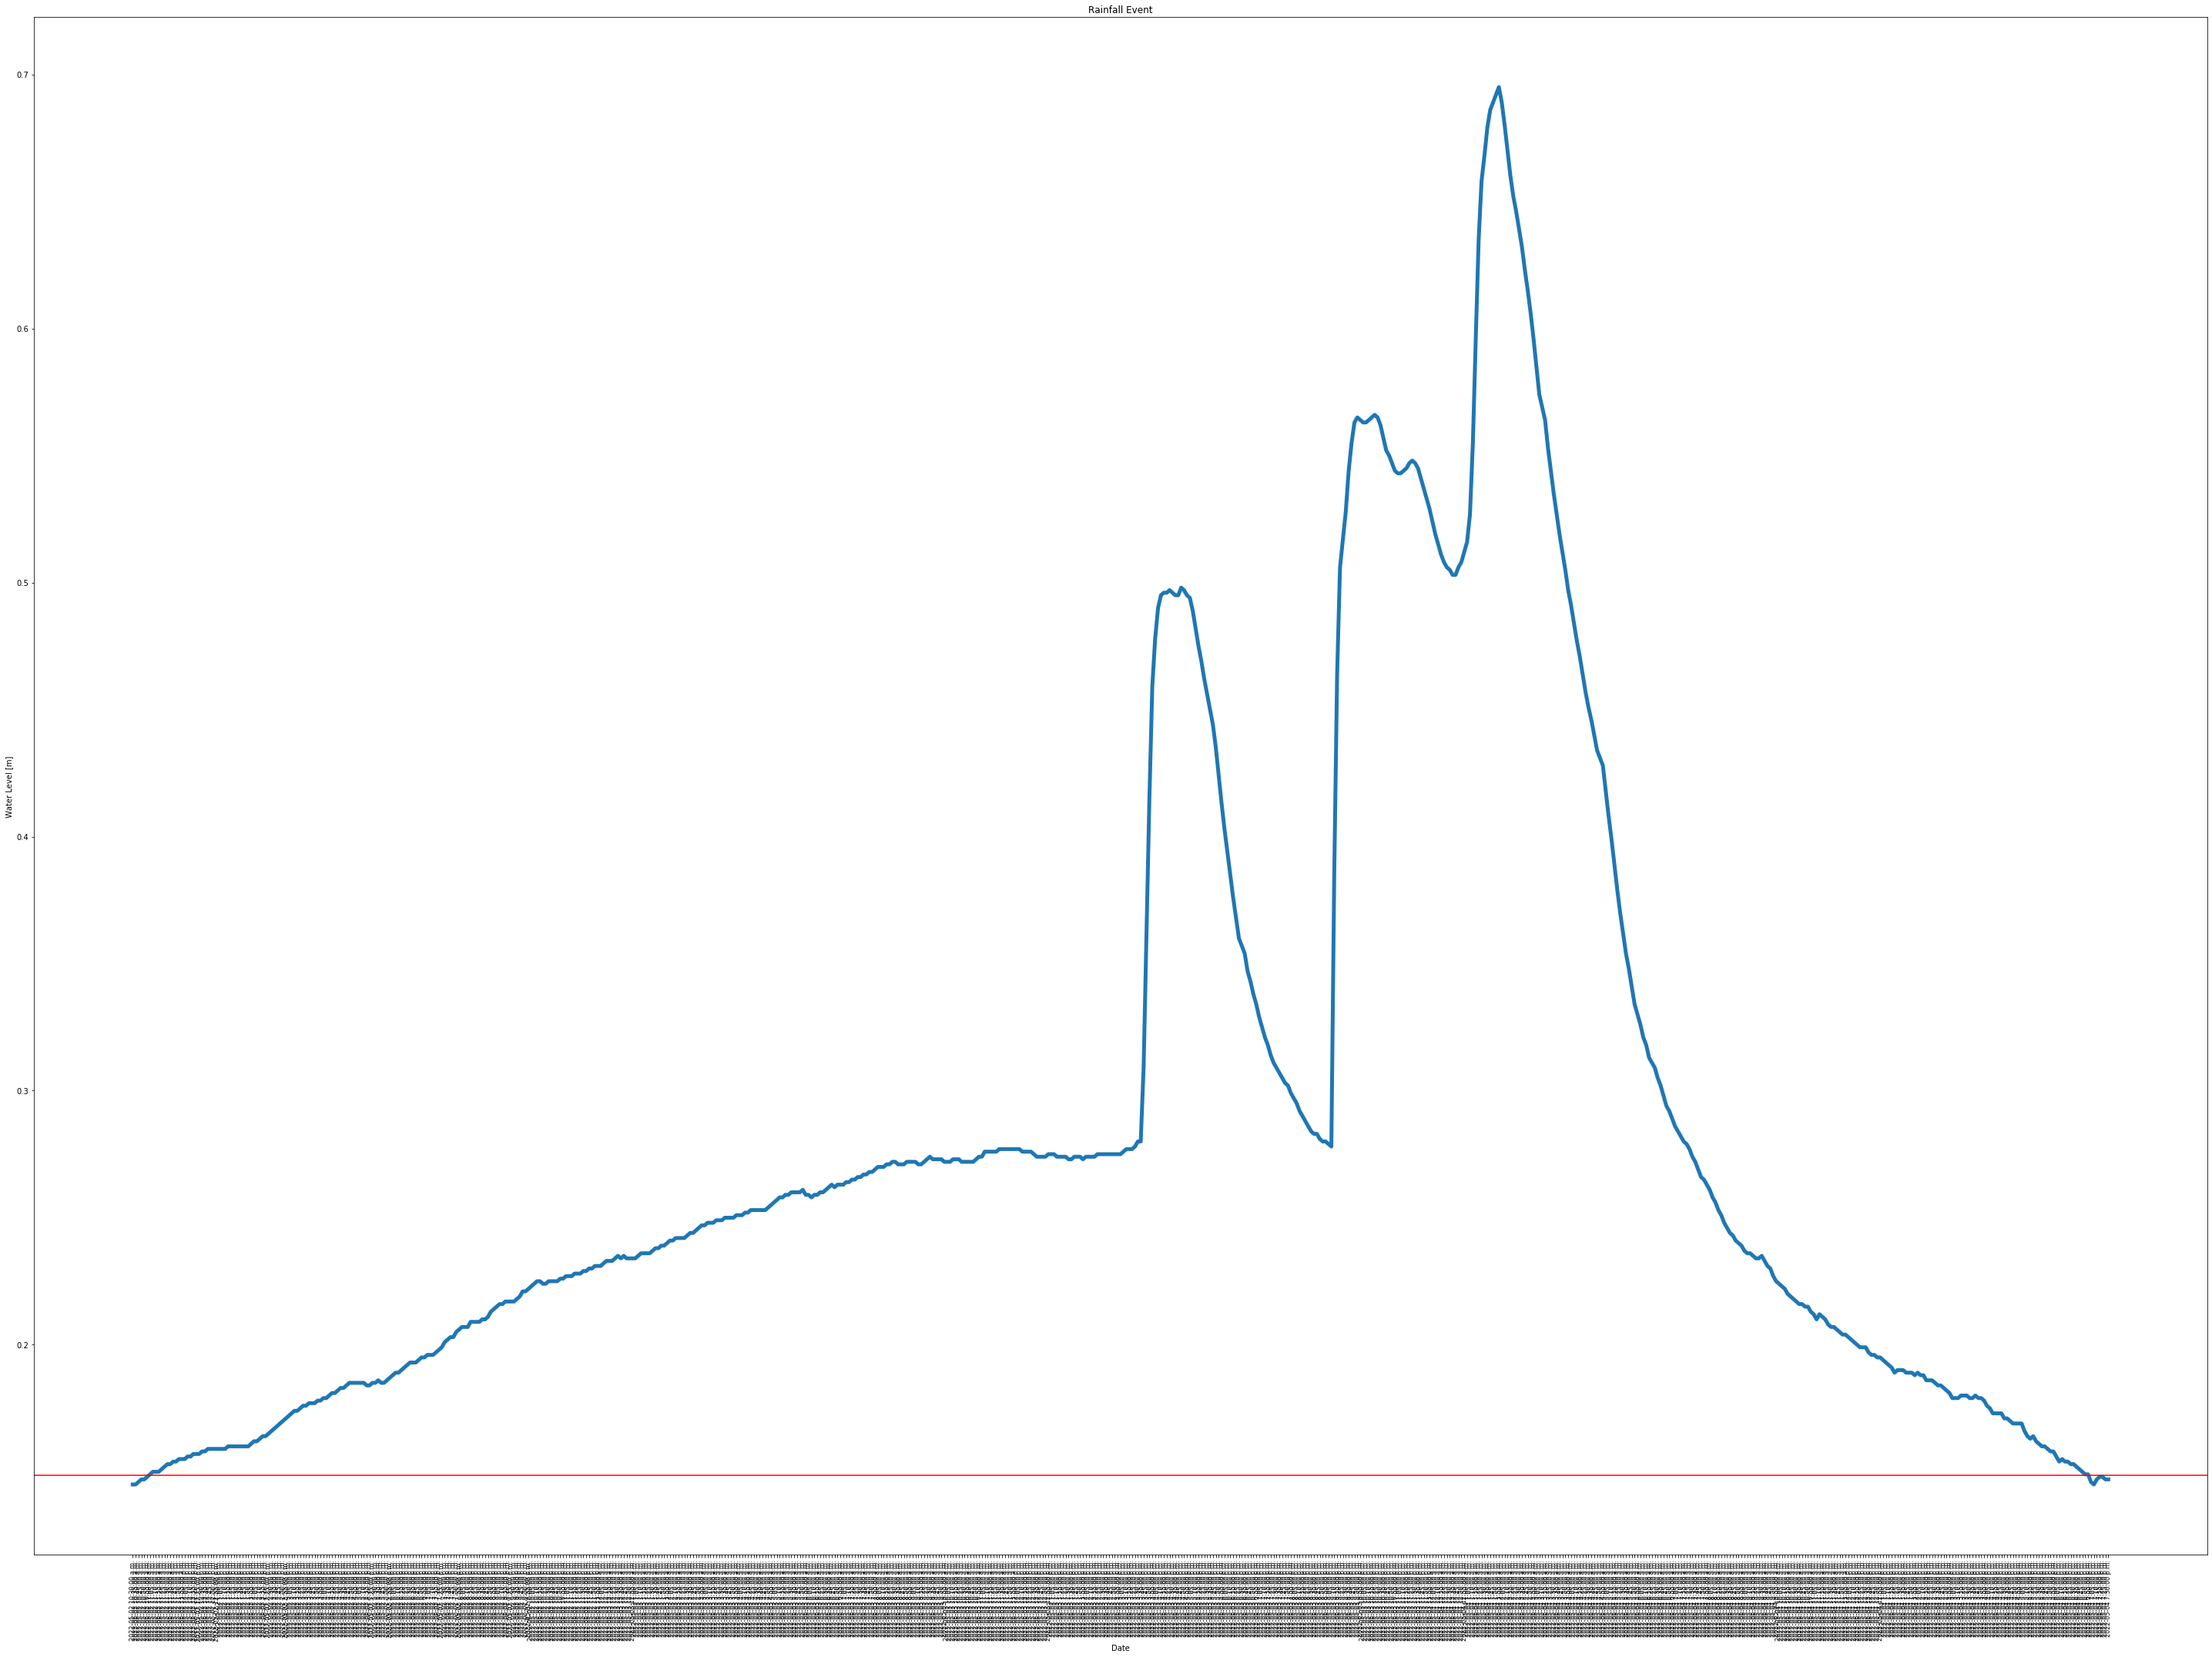

In [28]:
# Rainfall event
buffer=6
index=1
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

In [30]:
buffer=6
index=2
sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"].describe()

count    253.000000
mean       0.464237
std        0.252375
min        0.066000
25%        0.185000
50%        0.529000
75%        0.688000
max        0.887000
Name:  Water Level [m], dtype: float64

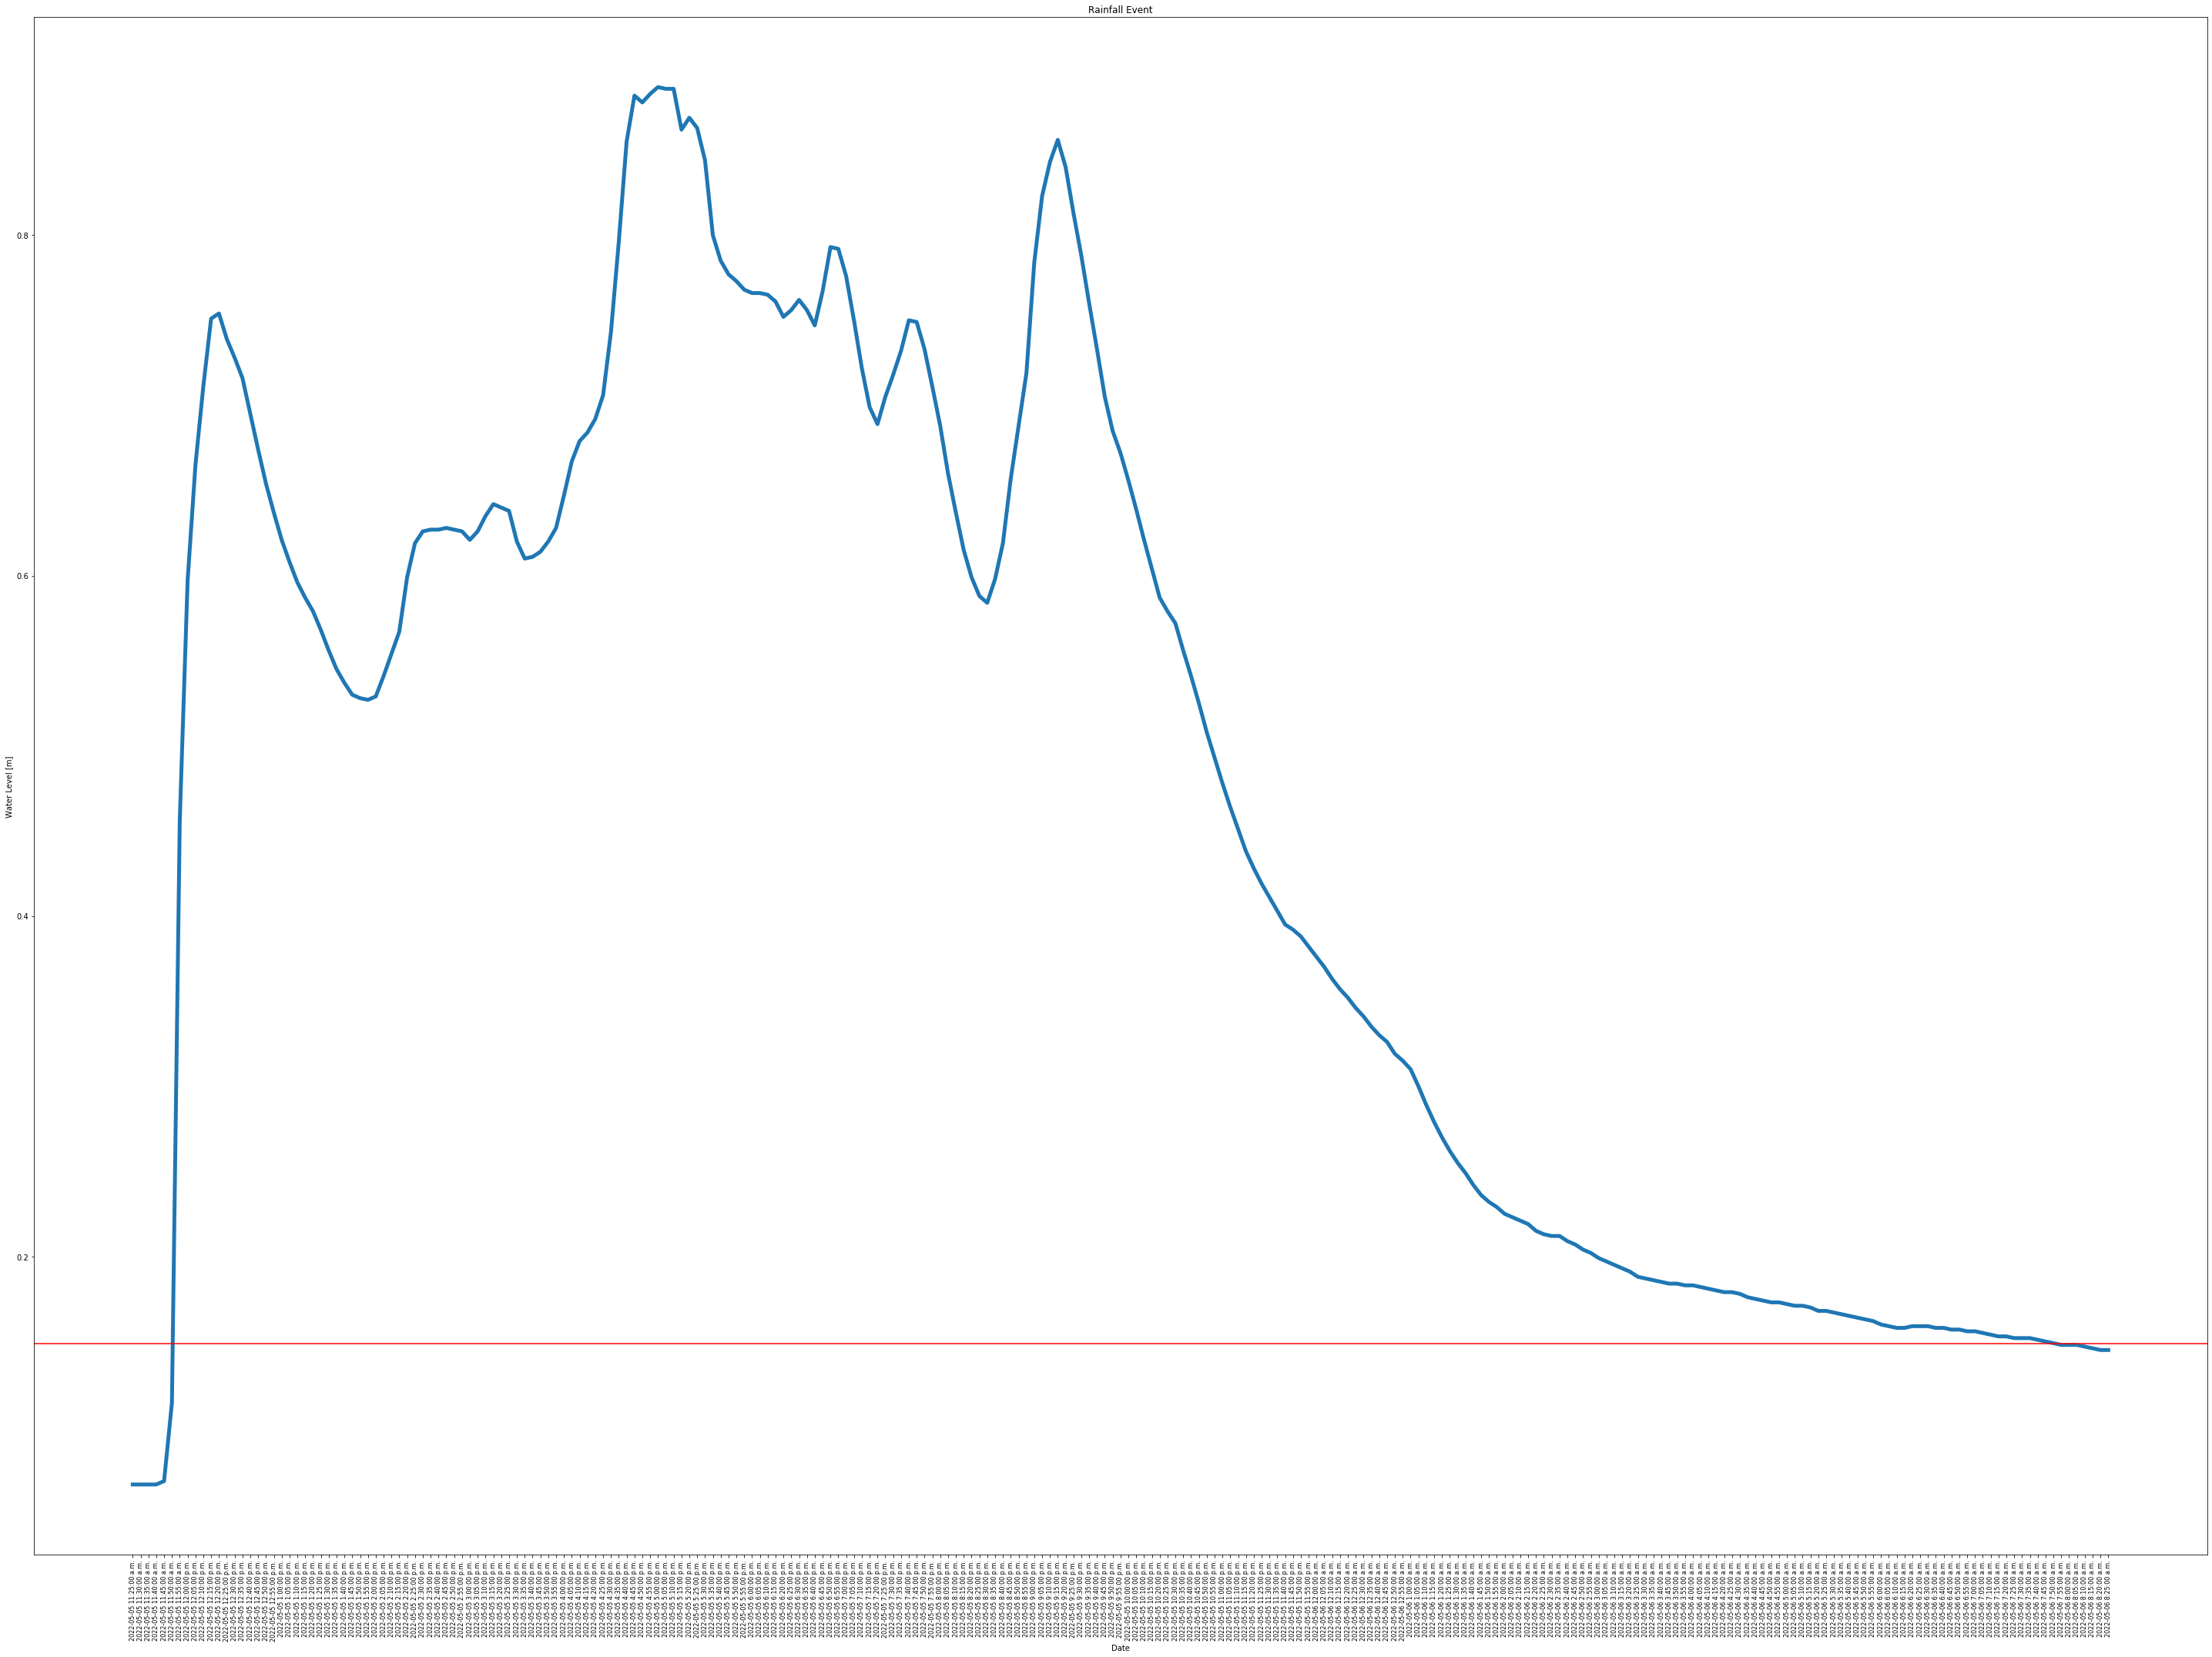

In [29]:
# Rainfall event
buffer=6
index=2
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

In [42]:
buffer=6
index=0
a=sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"].describe()
a

count    21653.000000
mean         0.451833
std          0.248315
min          0.144000
25%          0.259000
50%          0.422000
75%          0.512000
max          1.428000
Name:  Water Level [m], dtype: float64

In [50]:
tolA=a[5]
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA=IdentifyRainfall(sADF.loc[0:21646],tolA)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:40:00 a.m.,2022-02-19 10:20:00 p.m.,1087,1215,128
1,2022-02-21 4:00:00 a.m.,2022-02-21 6:50:00 a.m.,1571,1605,34
2,2022-02-26 5:35:00 p.m.,2022-02-27 11:45:00 a.m.,3174,3392,218
3,2022-02-27 6:30:00 p.m.,2022-02-28 11:40:00 p.m.,3473,3823,350
4,2022-03-01 4:30:00 p.m.,2022-03-03 10:20:00 a.m.,4025,4527,502
5,2022-03-11 9:05:00 p.m.,2022-03-12 1:50:00 p.m.,6960,7161,201
6,2022-03-13 7:05:00 a.m.,2022-03-16 3:40:00 a.m.,7356,8179,823
7,2022-03-17 7:05:00 a.m.,2022-03-20 3:00:00 a.m.,8508,9323,815
8,2022-03-20 2:25:00 p.m.,2022-03-25 6:20:00 p.m.,9460,10947,1487
9,2022-03-26 5:10:00 a.m.,2022-04-04 5:25:00 a.m.,11077,13672,2595


In [55]:
buffer=6
index=9
sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"].describe()

count    2608.000000
mean        0.557649
std         0.158784
min         0.375000
25%         0.497000
50%         0.508000
75%         0.524000
max         1.221000
Name:  Water Level [m], dtype: float64

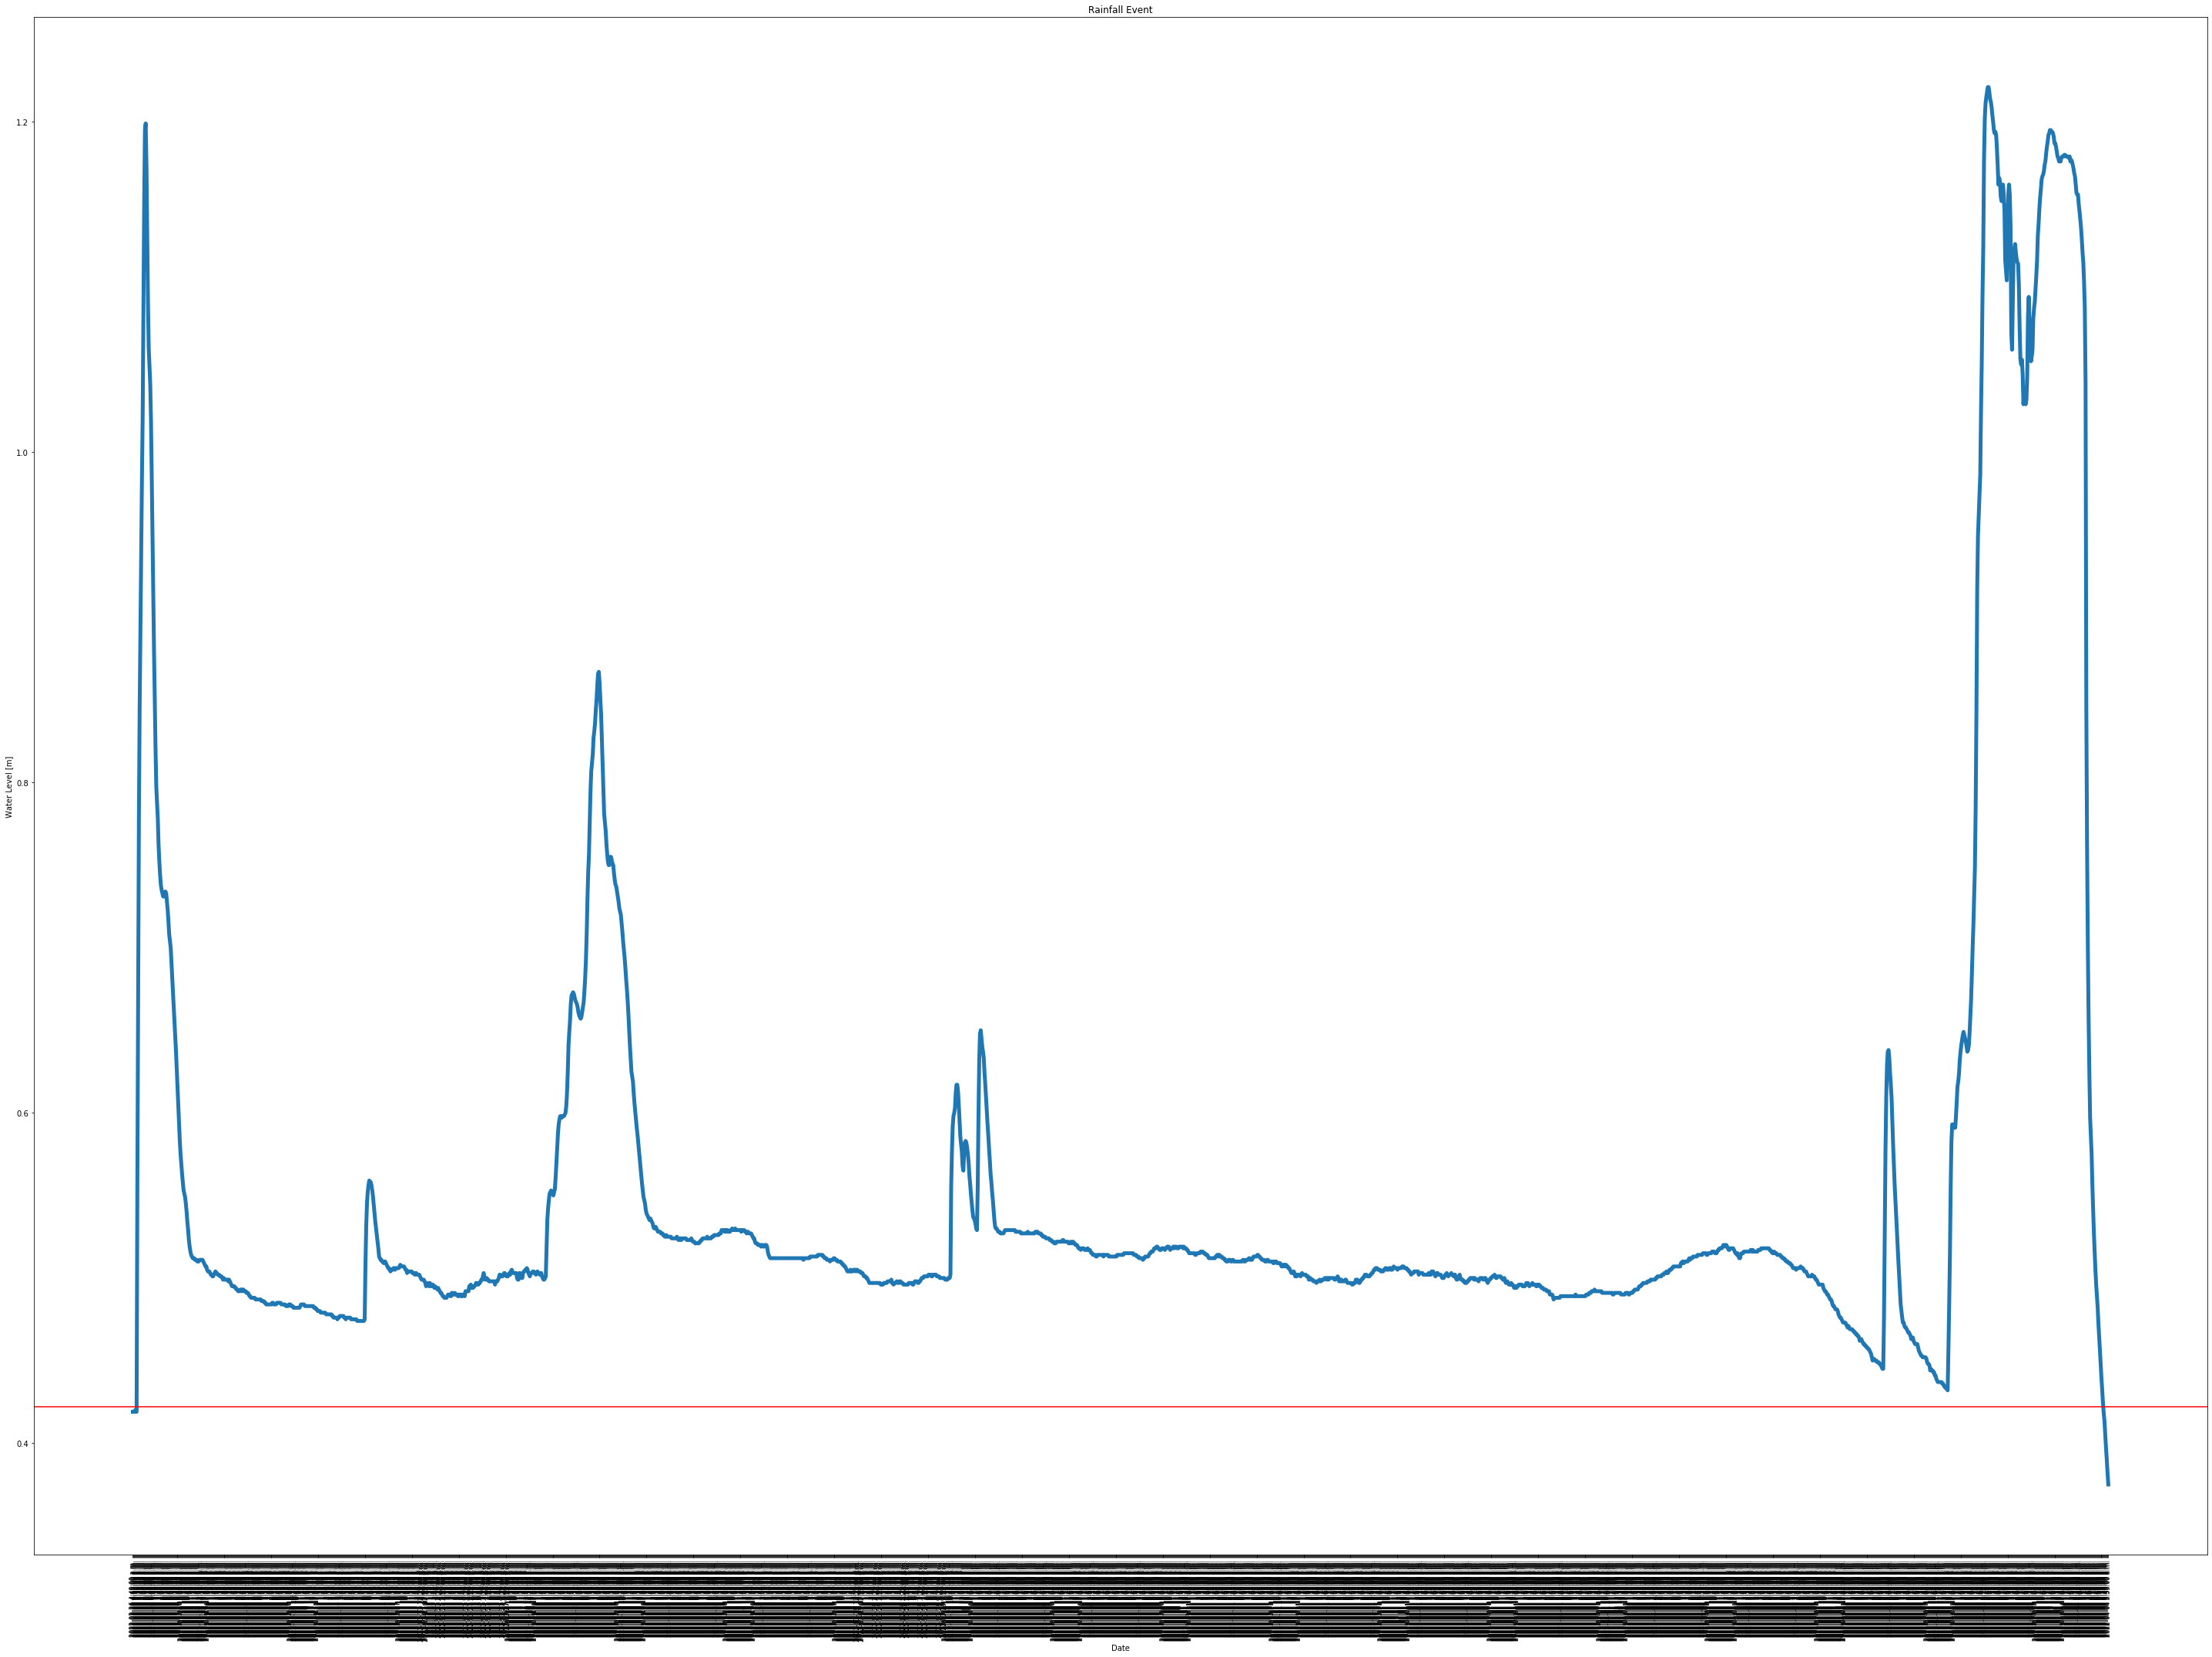

In [56]:
# Rainfall event
buffer=6
index=9
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

In [57]:
start_timeB,end_timeB,start_indexB,end_indexB,rf_durationB=IdentifyRainfall(sBDF,tolB)
rf_eventB=pd.DataFrame({"Rainfall_start_time":start_timeB,"Rainfall_end_time":end_timeB,"Rainfall_start_index":start_indexB,"Rainfall_end_index":end_indexB,"Rainfall_duration":rf_durationB})
rf_eventB

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-26 7:30:00 p.m.,2022-03-07 5:35:00 p.m.,3198,5767,2569
1,2022-03-12 2:50:00 a.m.,2022-04-02 5:00:00 a.m.,7030,13092,6062
2,2022-04-03 4:05:00 p.m.,2022-04-10 10:20:00 a.m.,13513,15460,1947
3,2022-04-12 11:00:00 a.m.,2022-04-17 6:35:00 a.m.,16044,17431,1387
4,2022-04-18 5:55:00 a.m.,2022-04-28 10:25:00 p.m.,17711,20789,3078
5,2022-04-30 11:05:00 a.m.,2022-05-02 2:50:00 p.m.,21229,21850,621
6,2022-05-05 11:45:00 a.m.,2022-05-10 11:45:00 a.m.,22677,24117,1440
7,2022-05-12 2:05:00 a.m.,2022-05-12 2:15:00 a.m.,24577,24579,2
8,2022-05-12 1:30:00 p.m.,2022-05-22 8:25:00 a.m.,24714,27533,2819
9,2022-05-26 10:50:00 p.m.,2022-05-30 7:20:00 p.m.,28858,29968,1110


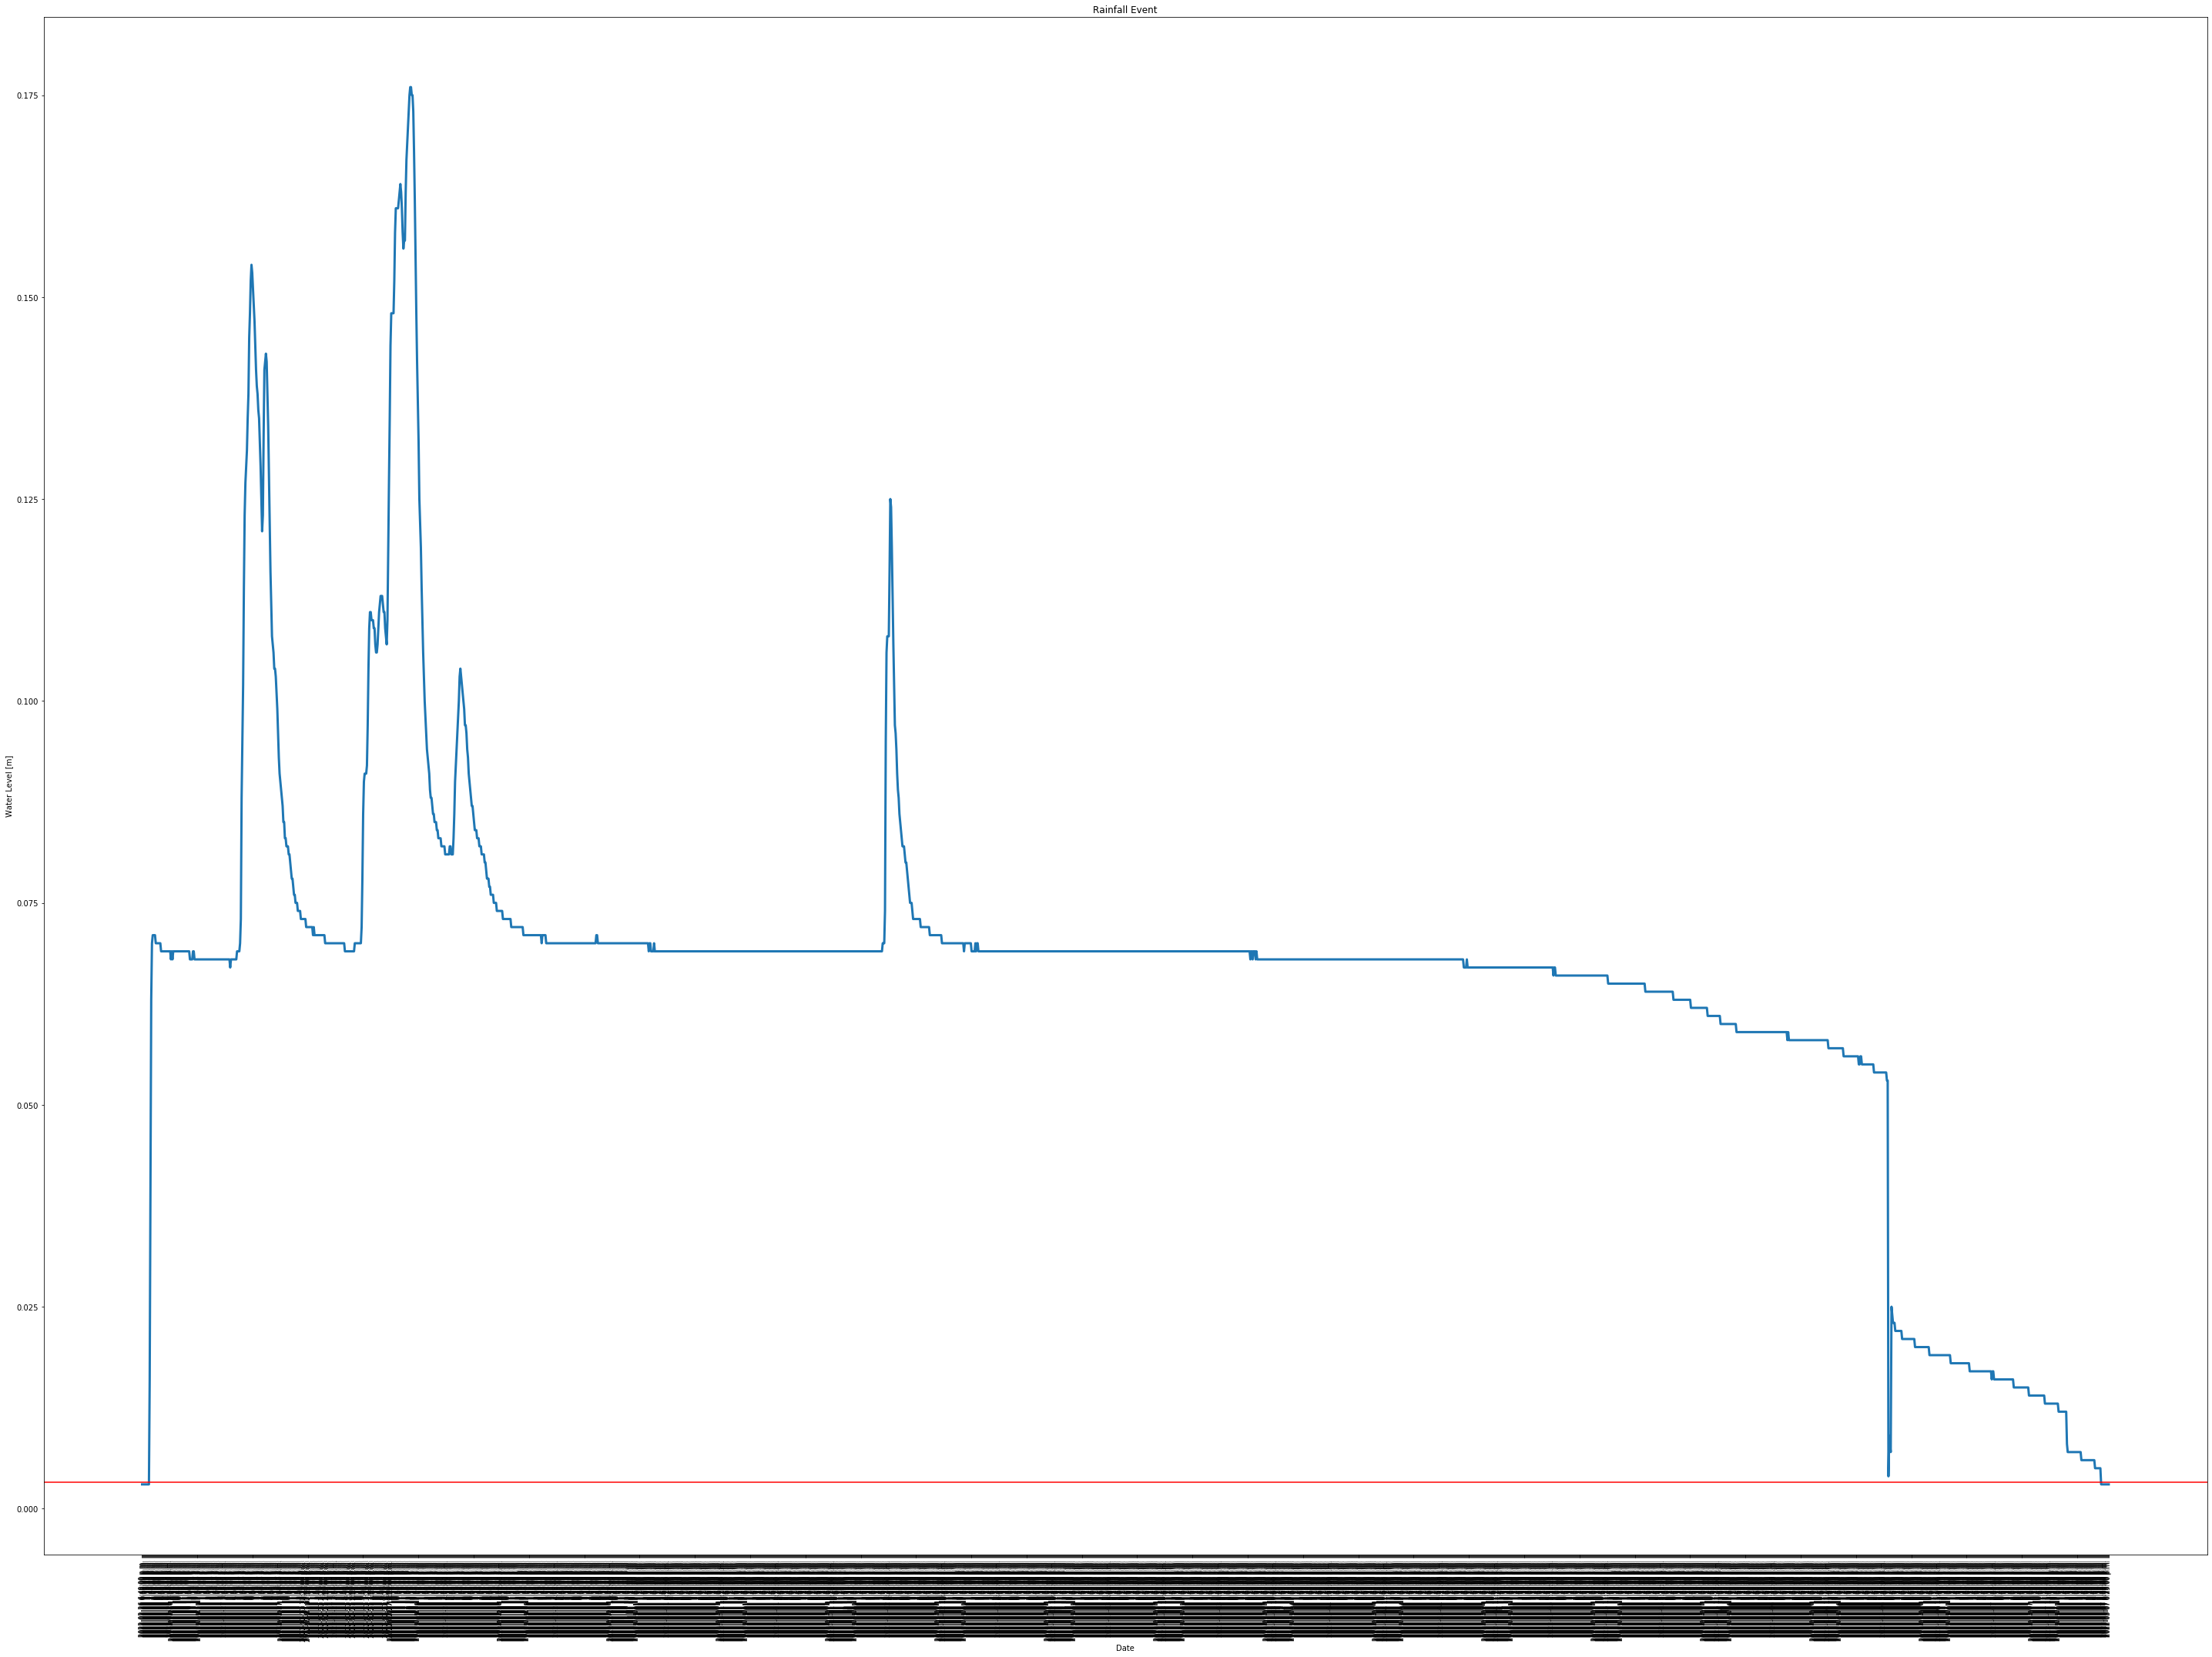

In [287]:
# Rainfall event
buffer=10
index=0
X=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer][" Water Level [m]"])


plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=3)
plt.axhline(y=tolB, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

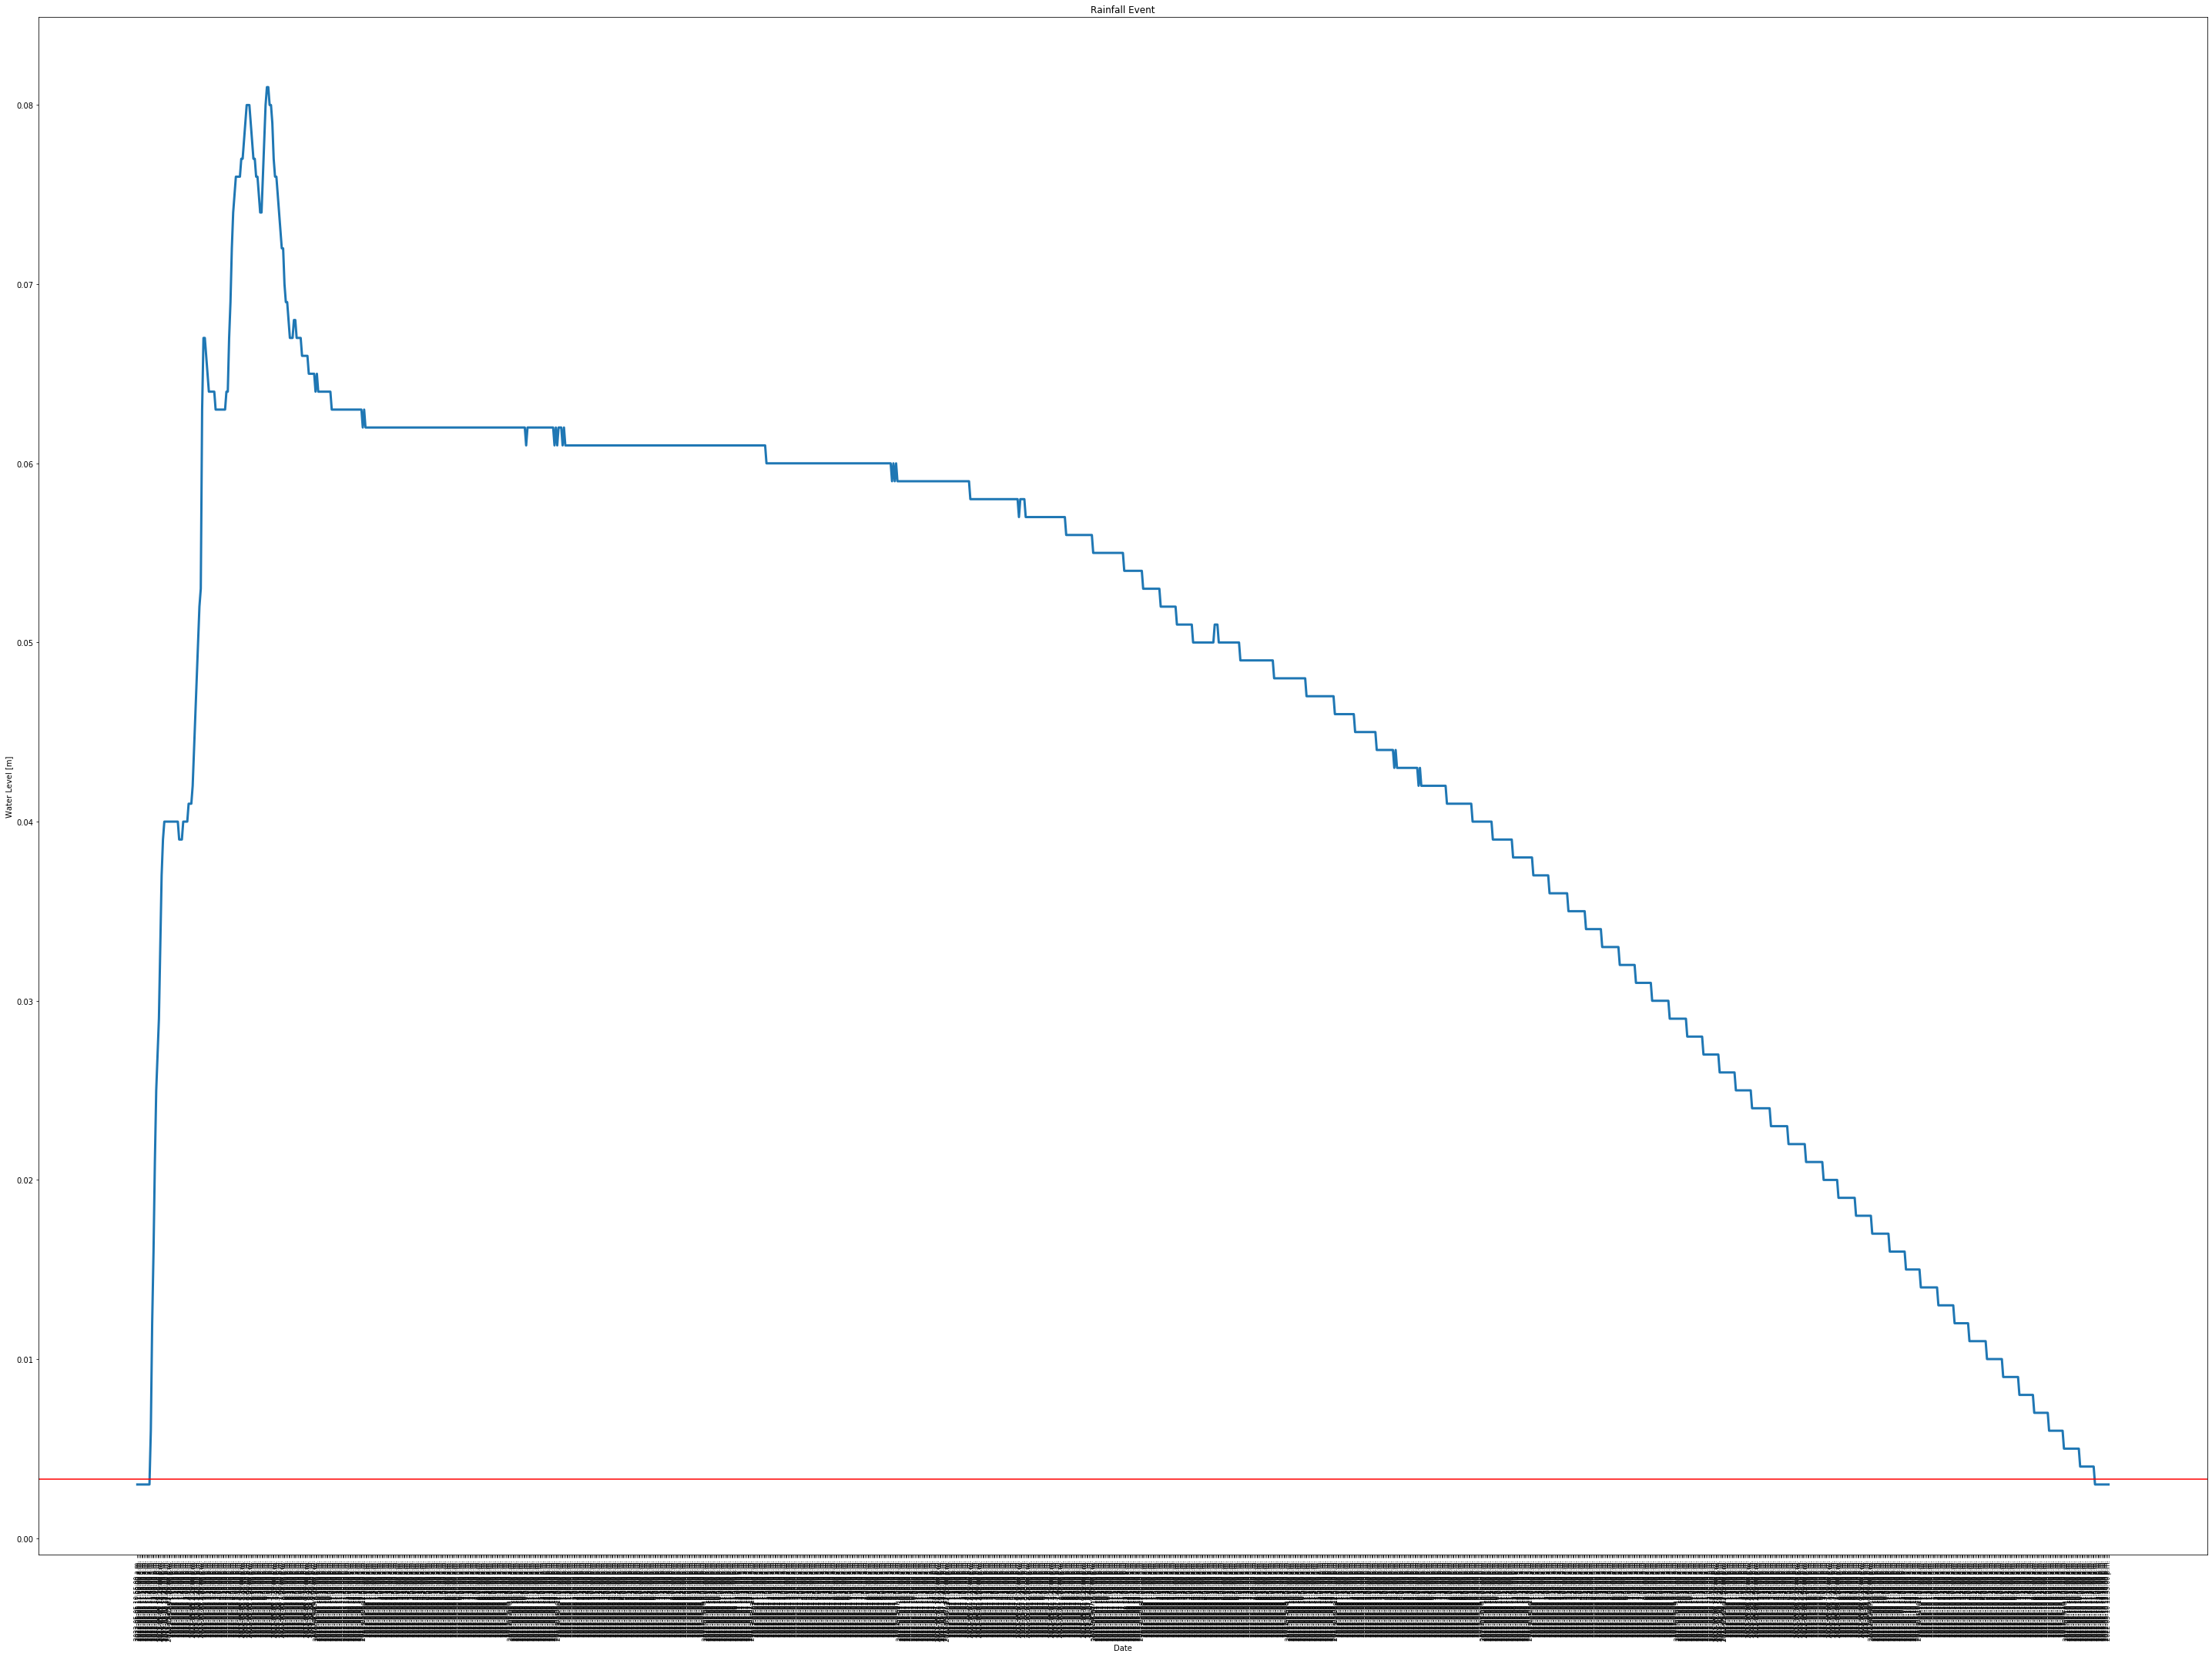

In [286]:
# Rainfall event
buffer=10
index=6
X=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer][" Water Level [m]"])


plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=3)
plt.axhline(y=tolB, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

In [59]:
start_timeB,end_timeB,start_indexB,end_indexB,rf_durationB=IdentifyRainfall(sBDF,0.075)
rf_eventB=pd.DataFrame({"Rainfall_start_time":start_timeB,"Rainfall_end_time":end_timeB,"Rainfall_start_index":start_indexB,"Rainfall_end_index":end_indexB,"Rainfall_duration":rf_durationB})
rf_eventB

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-27 5:35:00 a.m.,2022-02-27 11:45:00 a.m.,3319,3393,74
1,2022-02-27 6:50:00 p.m.,2022-02-28 9:35:00 a.m.,3478,3655,177
2,2022-03-02 4:15:00 a.m.,2022-03-02 7:10:00 a.m.,4167,4202,35
3,2022-03-12 6:00:00 a.m.,2022-03-12 6:10:00 a.m.,7068,7070,2
4,2022-03-13 10:50:00 p.m.,2022-03-15 6:20:00 a.m.,7546,7924,378
5,2022-03-17 9:05:00 a.m.,2022-03-17 4:10:00 p.m.,8533,8618,85
6,2022-03-20 10:30:00 p.m.,2022-03-21 7:20:00 a.m.,9558,9664,106
7,2022-03-22 2:15:00 a.m.,2022-03-22 4:30:00 a.m.,9891,9918,27
8,2022-03-23 12:00:00 p.m.,2022-03-23 12:10:00 p.m.,10296,10298,2
9,2022-03-26 6:25:00 a.m.,2022-03-26 7:10:00 a.m.,11093,11102,9


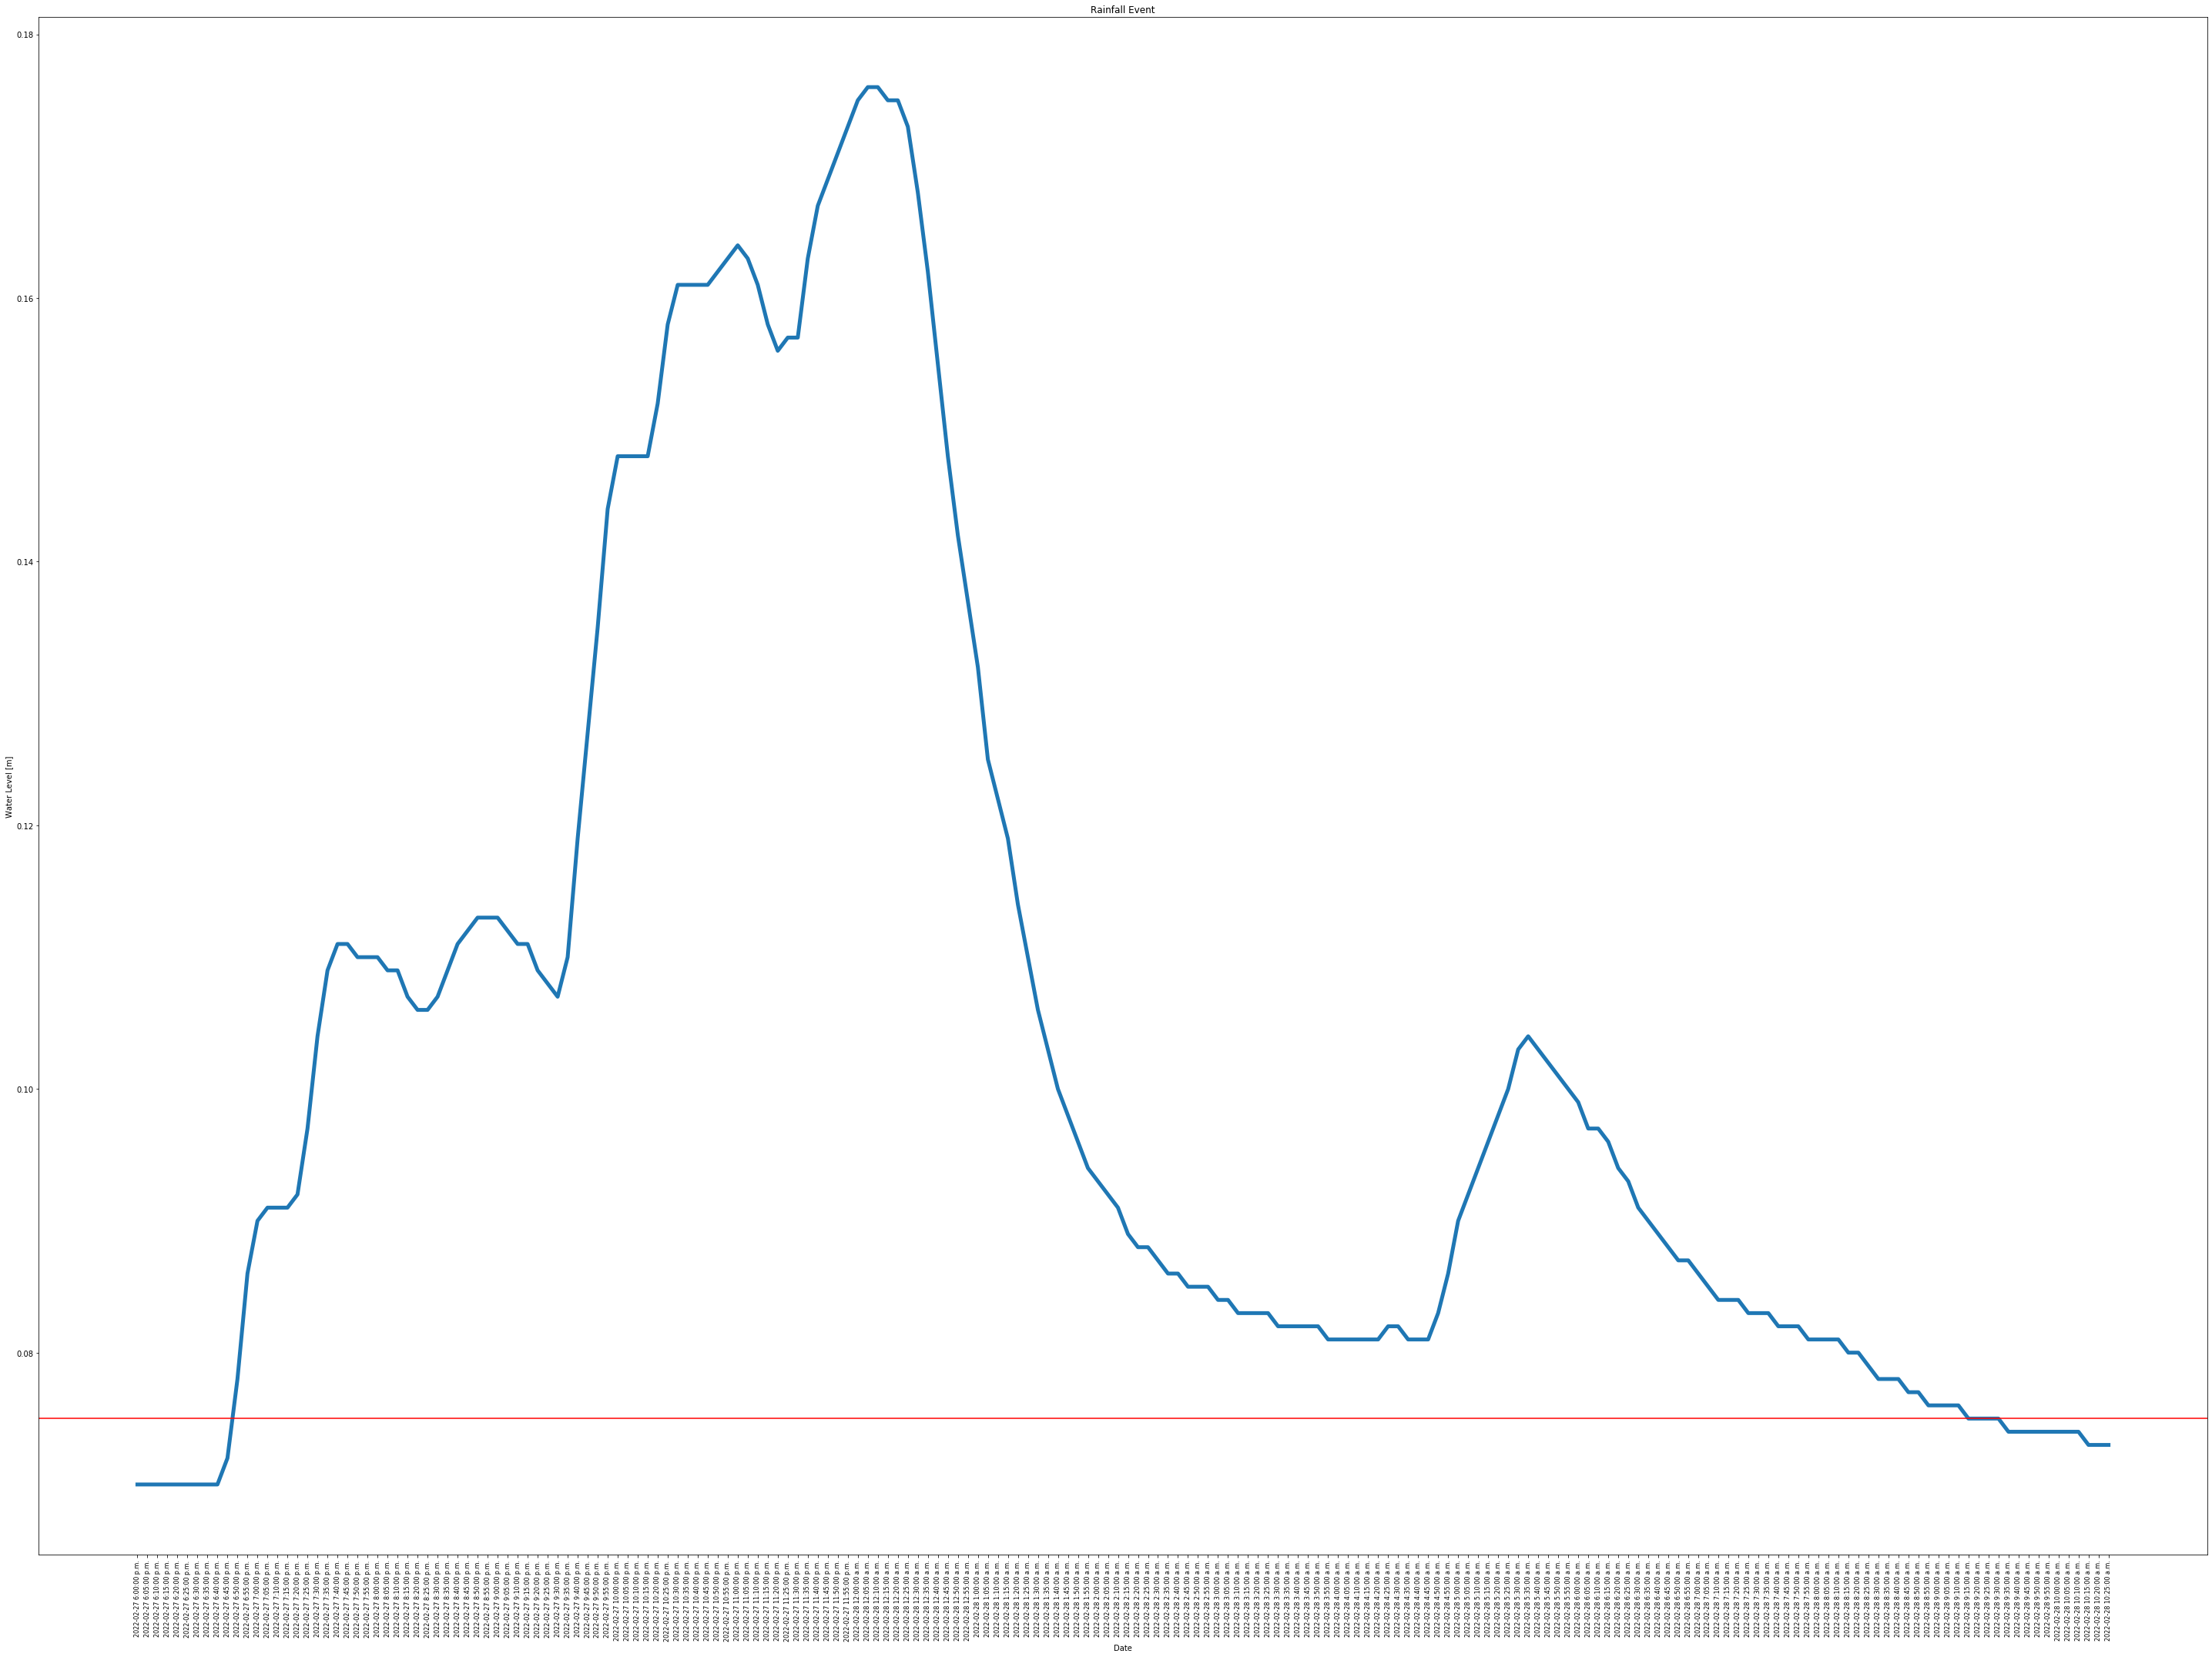

In [61]:
# Rainfall event
buffer=10
index=1
X=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
plt.axhline(y=0.075, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

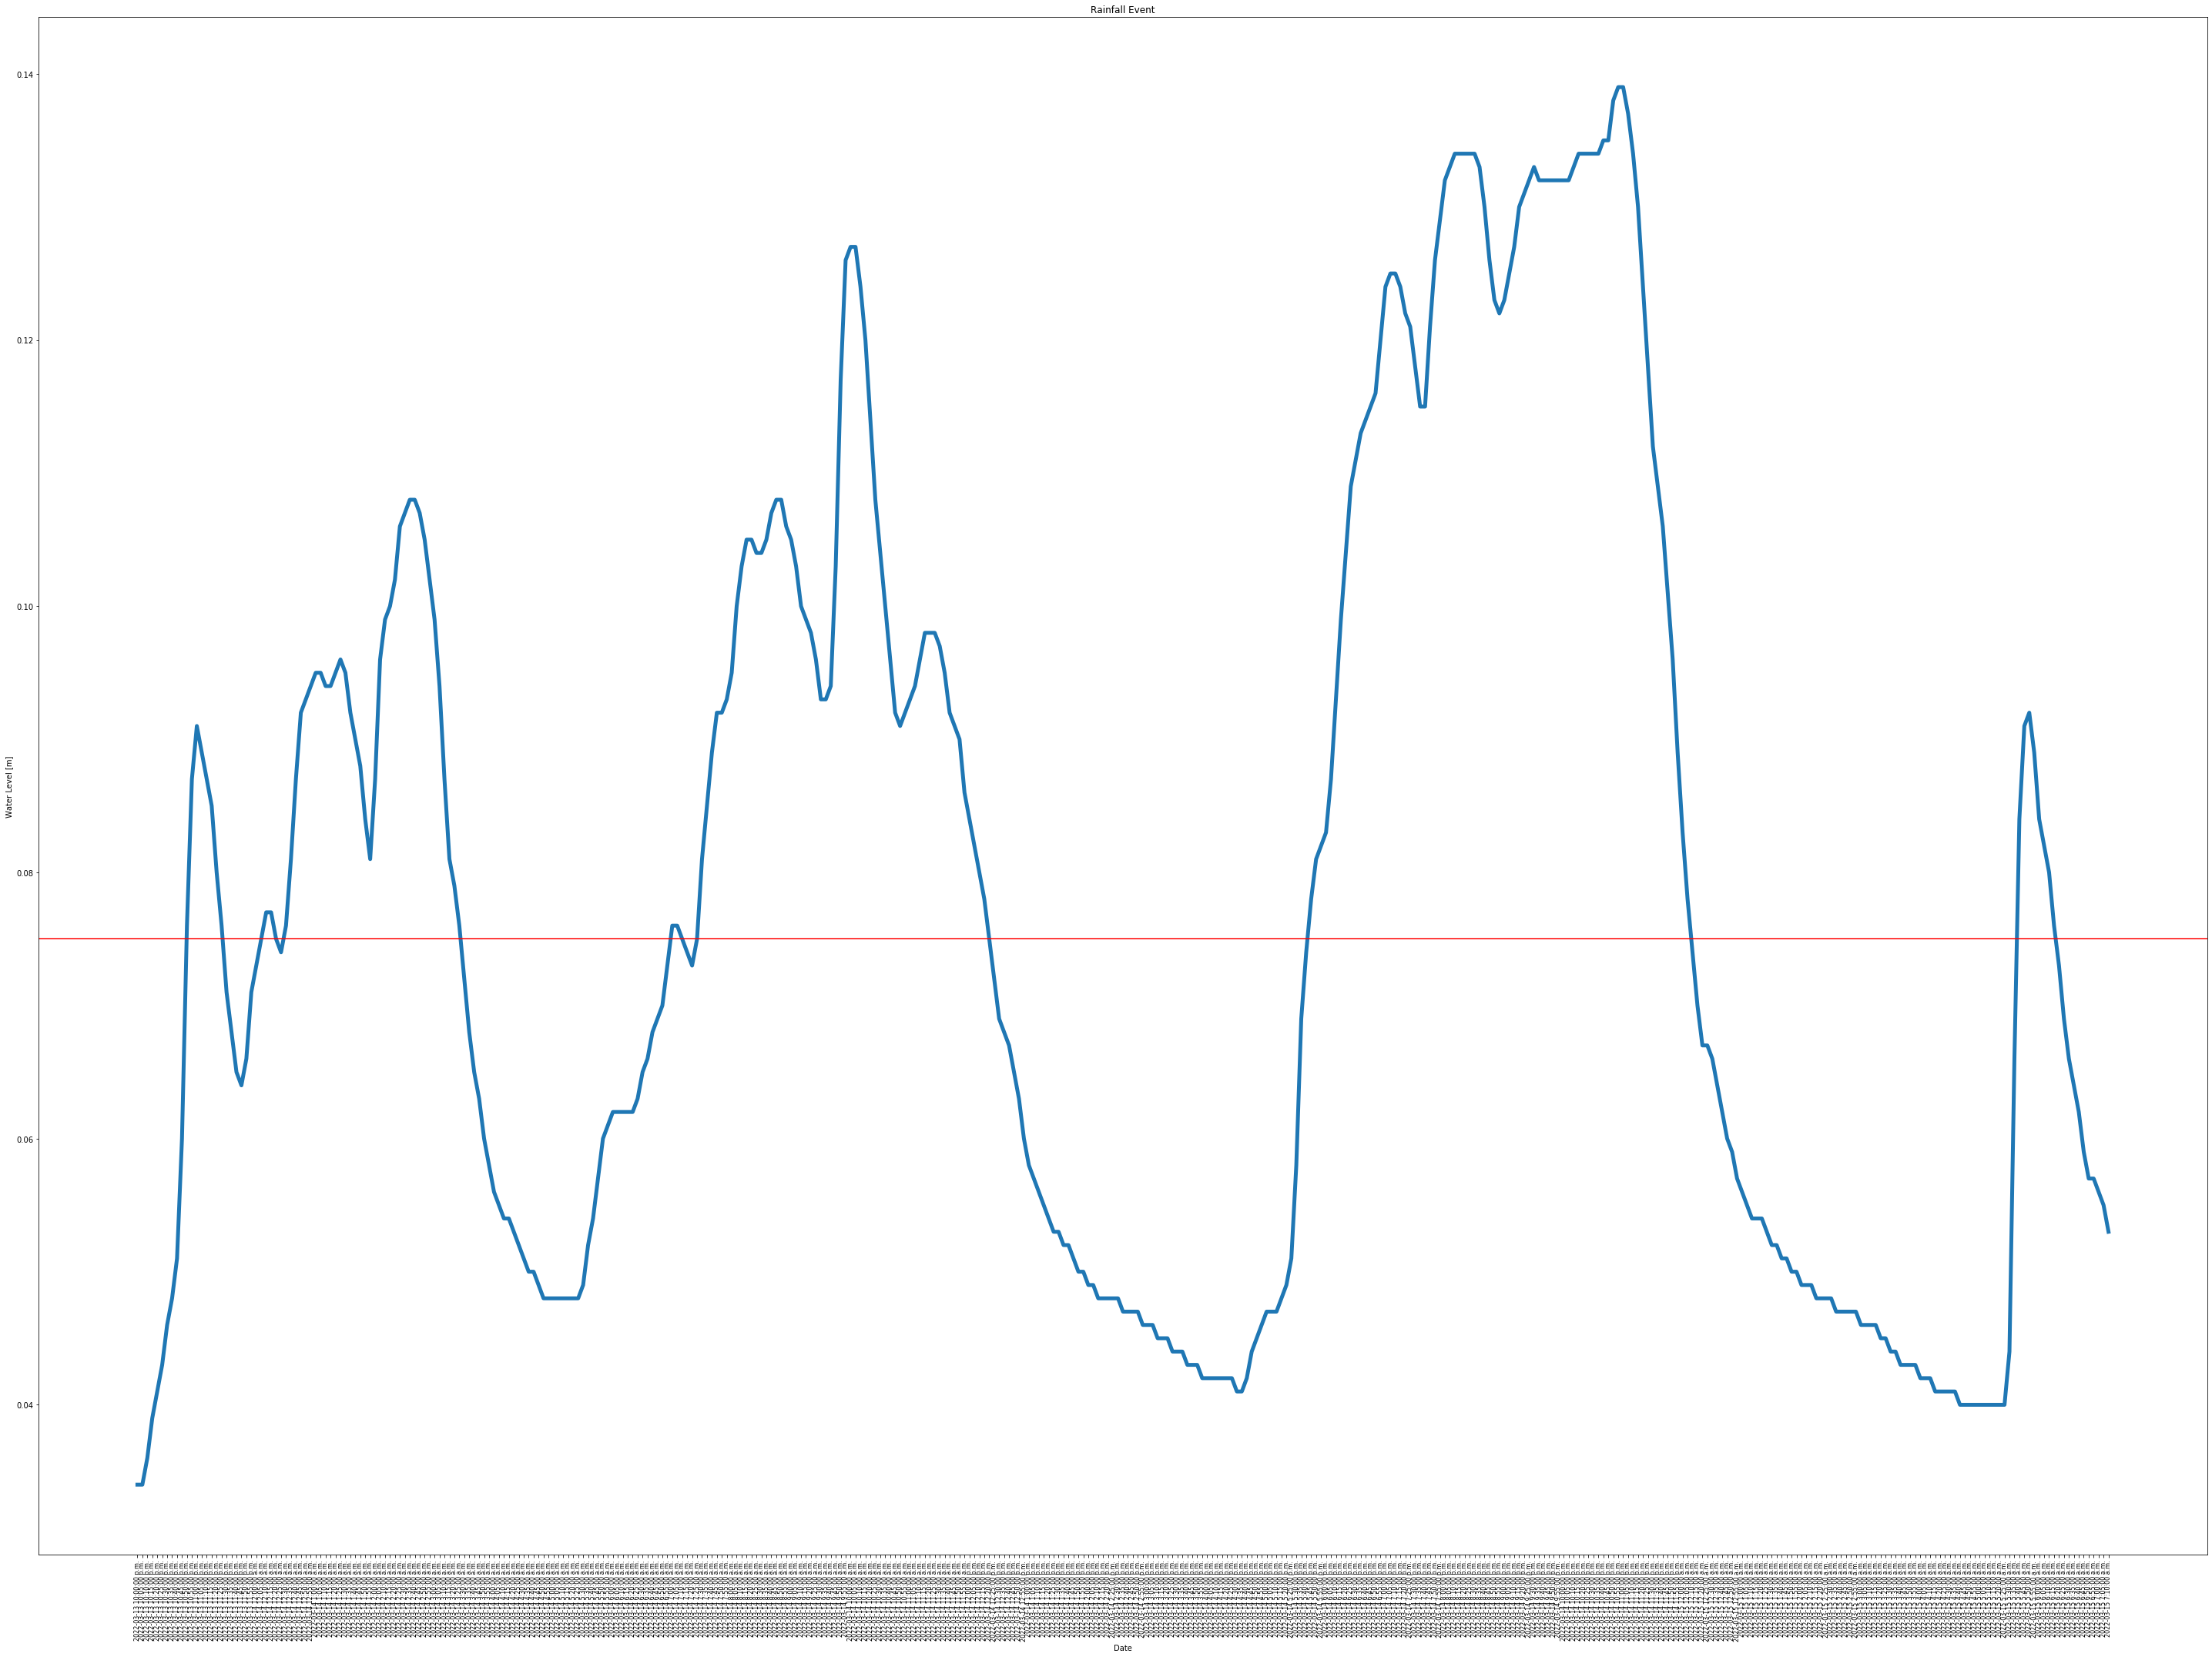

In [62]:
# Rainfall event
buffer=10
index=4
X=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sBDF.loc[rf_eventB["Rainfall_start_index"][index]-buffer:rf_eventB["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
plt.axhline(y=0.075, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

In [64]:
sADF.head()

,Timestamp,Water Level [m]
0,2022-02-15 5:05:00 p.m.,0.238
1,2022-02-15 5:10:00 p.m.,0.237
2,2022-02-15 5:15:00 p.m.,0.236
3,2022-02-15 5:20:00 p.m.,0.235
4,2022-02-15 5:25:00 p.m.,0.234


In [91]:
water_level_change_mm=np.diff(sADF[" Water Level [m]"])*1000
abs(water_level_change_mm[0])

In [93]:
plt.figure(figsize=(40, 30))
plt.plot(water_level_change_mm)
plt.axhline(y=20, color='r', linestyle='-')
plt.axhline(y=-20, color='r', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Water Level Change mm')
plt.show()

array([0.238, 0.237, 0.236, ..., 0.025, 0.025, 0.025])

In [129]:
def IdentifyEvents(df,tol):
    #  1st try
    wlc_mm=np.diff(df[" Water Level [m]"])*1000 # water level change measured in mm
    nre=True
    # rpc=0
    dpc=0
    start_time=[]
    end_time=[]
    start_index=[]
    end_index=[]
    duration=[]
    for i in range (df.shape[0]-1):
        if nre==True:
            rpc=0    # duration of rainfall set to zero
            if abs(wlc_mm[i])>tol:
                # This is a new rainfall event
                #print("A new rainfall started at time :",df["Timestamp"][i]," with index position :",i)
                start_time.append(df["Timestamp"][i])
                start_index.append(i)
                dpc=0     # Dry period count initialization
                rpc+=1      # count the duration of rainfall
                nre=False
                # continue
        else:
            if abs(wlc_mm[i])<tol: 
                dpc+=1
                skip=3*(5*12)    # 6 hours of no significant change in water level means start of another event
                # save this date 
                if dpc>skip:
                    nre=True
                    end_time.append(df["Timestamp"][i-skip])
                    end_index.append(i-skip)
                    duration.append(rpc-skip)
                    #print(f"Rainfall event ended at time :",df["Timestamp"][i-72]," with index position :",i-72,"\nDuration of this rainfall period was :",rpc-72)
                    #print("Now it is a dry period of more than 6 hours")
                    #print("***********************************" )
                    # continue
                else:
                    rpc+=1    # count the duration of rainfall
            else:
                dpc=0
                rpc+=1
    return start_time,end_time,start_index,end_index,duration,wlc_mm

In [106]:
start_timeA,end_timeA,start_indexA,end_indexA,rf_durationA,water_level_changeA=IdentifyEvents(sADF,10)
rf_eventA=pd.DataFrame({"Rainfall_start_time":start_timeA,"Rainfall_end_time":end_timeA,"Rainfall_start_index":start_indexA,"Rainfall_end_index":end_indexA,"Rainfall_duration":rf_durationA})
rf_eventA

,Rainfall_start_time,Rainfall_end_time,Rainfall_start_index,Rainfall_end_index,Rainfall_duration
0,2022-02-19 11:30:00 a.m.,2022-02-19 11:00:00 p.m.,1085,1223,138
1,2022-02-21 3:55:00 a.m.,2022-02-21 7:25:00 a.m.,1570,1612,42
2,2022-02-26 2:50:00 p.m.,2022-02-28 11:40:00 p.m.,3141,3823,682
3,2022-03-01 4:25:00 p.m.,2022-03-02 6:15:00 p.m.,4024,4334,310
4,2022-03-11 8:55:00 p.m.,2022-03-12 10:00:00 a.m.,6958,7115,157
5,2022-03-13 7:00:00 a.m.,2022-03-15 5:15:00 p.m.,7355,8054,699
6,2022-03-17 7:00:00 a.m.,2022-03-19 8:25:00 a.m.,8507,9100,593
7,2022-03-20 2:20:00 p.m.,2022-03-22 3:45:00 p.m.,9459,10052,593
8,2022-03-23 9:25:00 a.m.,2022-03-23 1:20:00 p.m.,10264,10311,47
9,2022-03-26 5:05:00 a.m.,2022-03-26 9:50:00 a.m.,11076,11133,57


In [108]:

water_level=sADF[" Water Level [m]"].to_numpy()*1000  # water level in mm

array([238., 237., 236., ...,  25.,  25.,  25.])

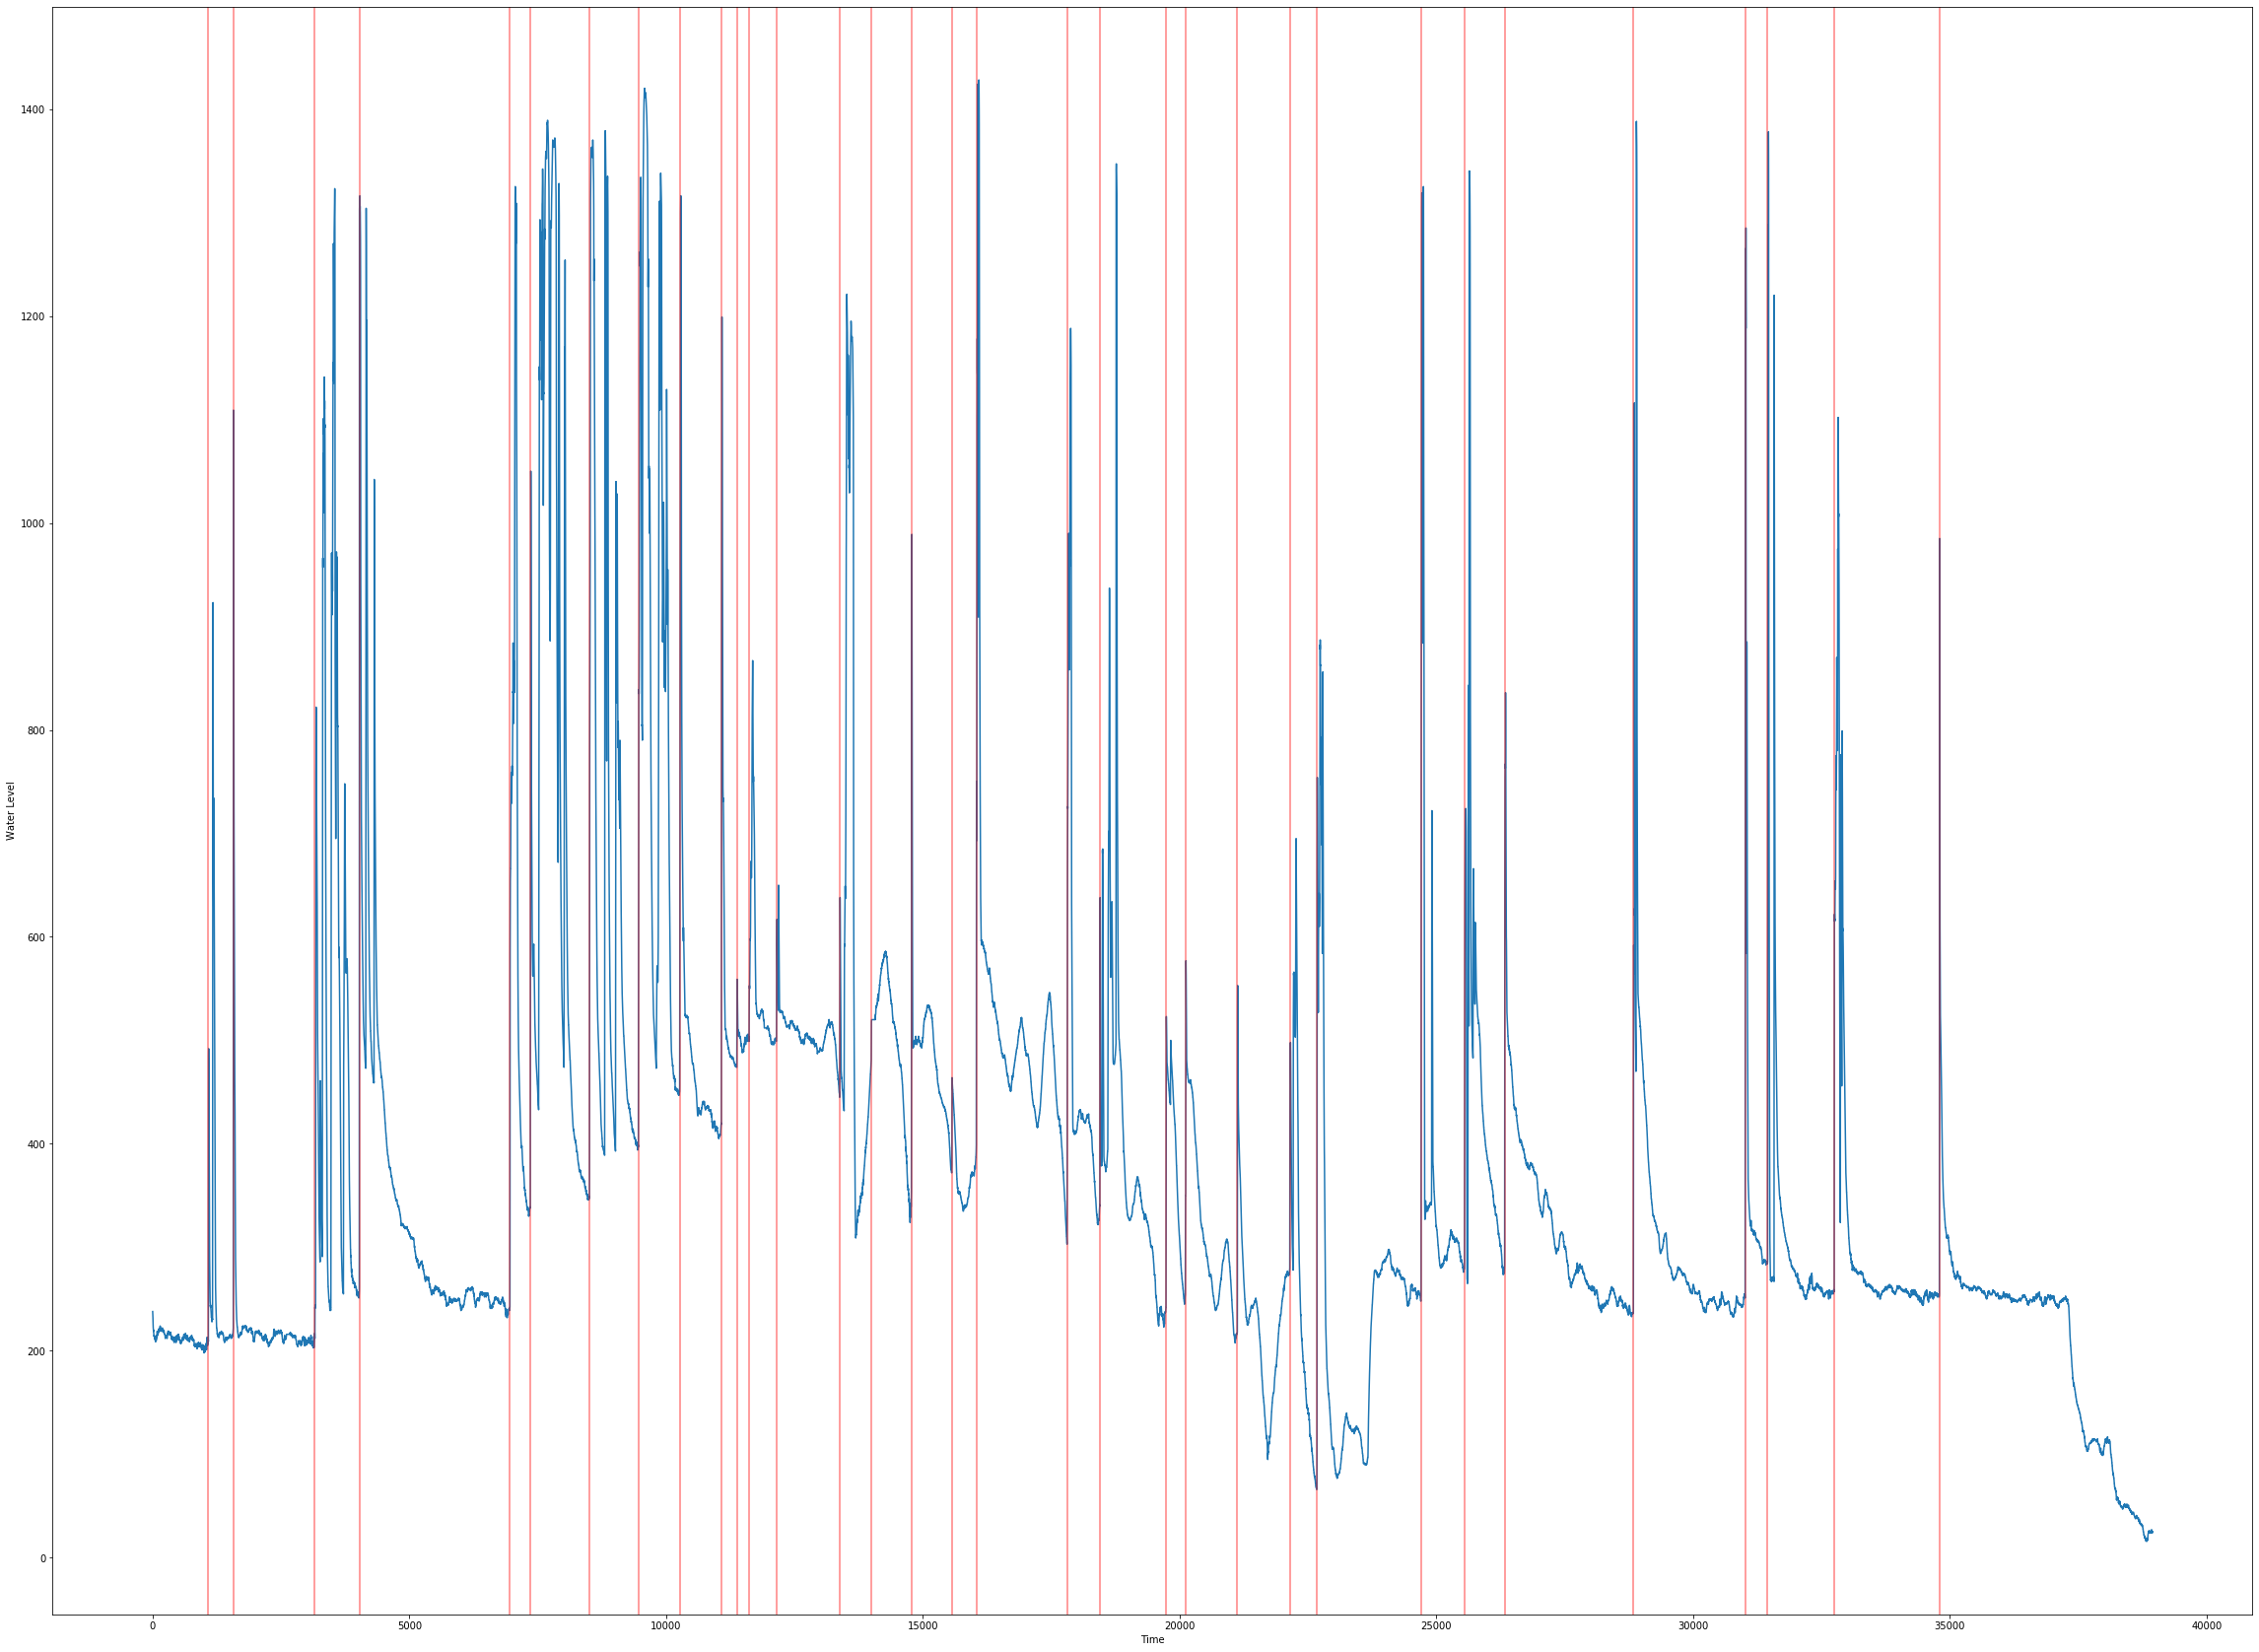

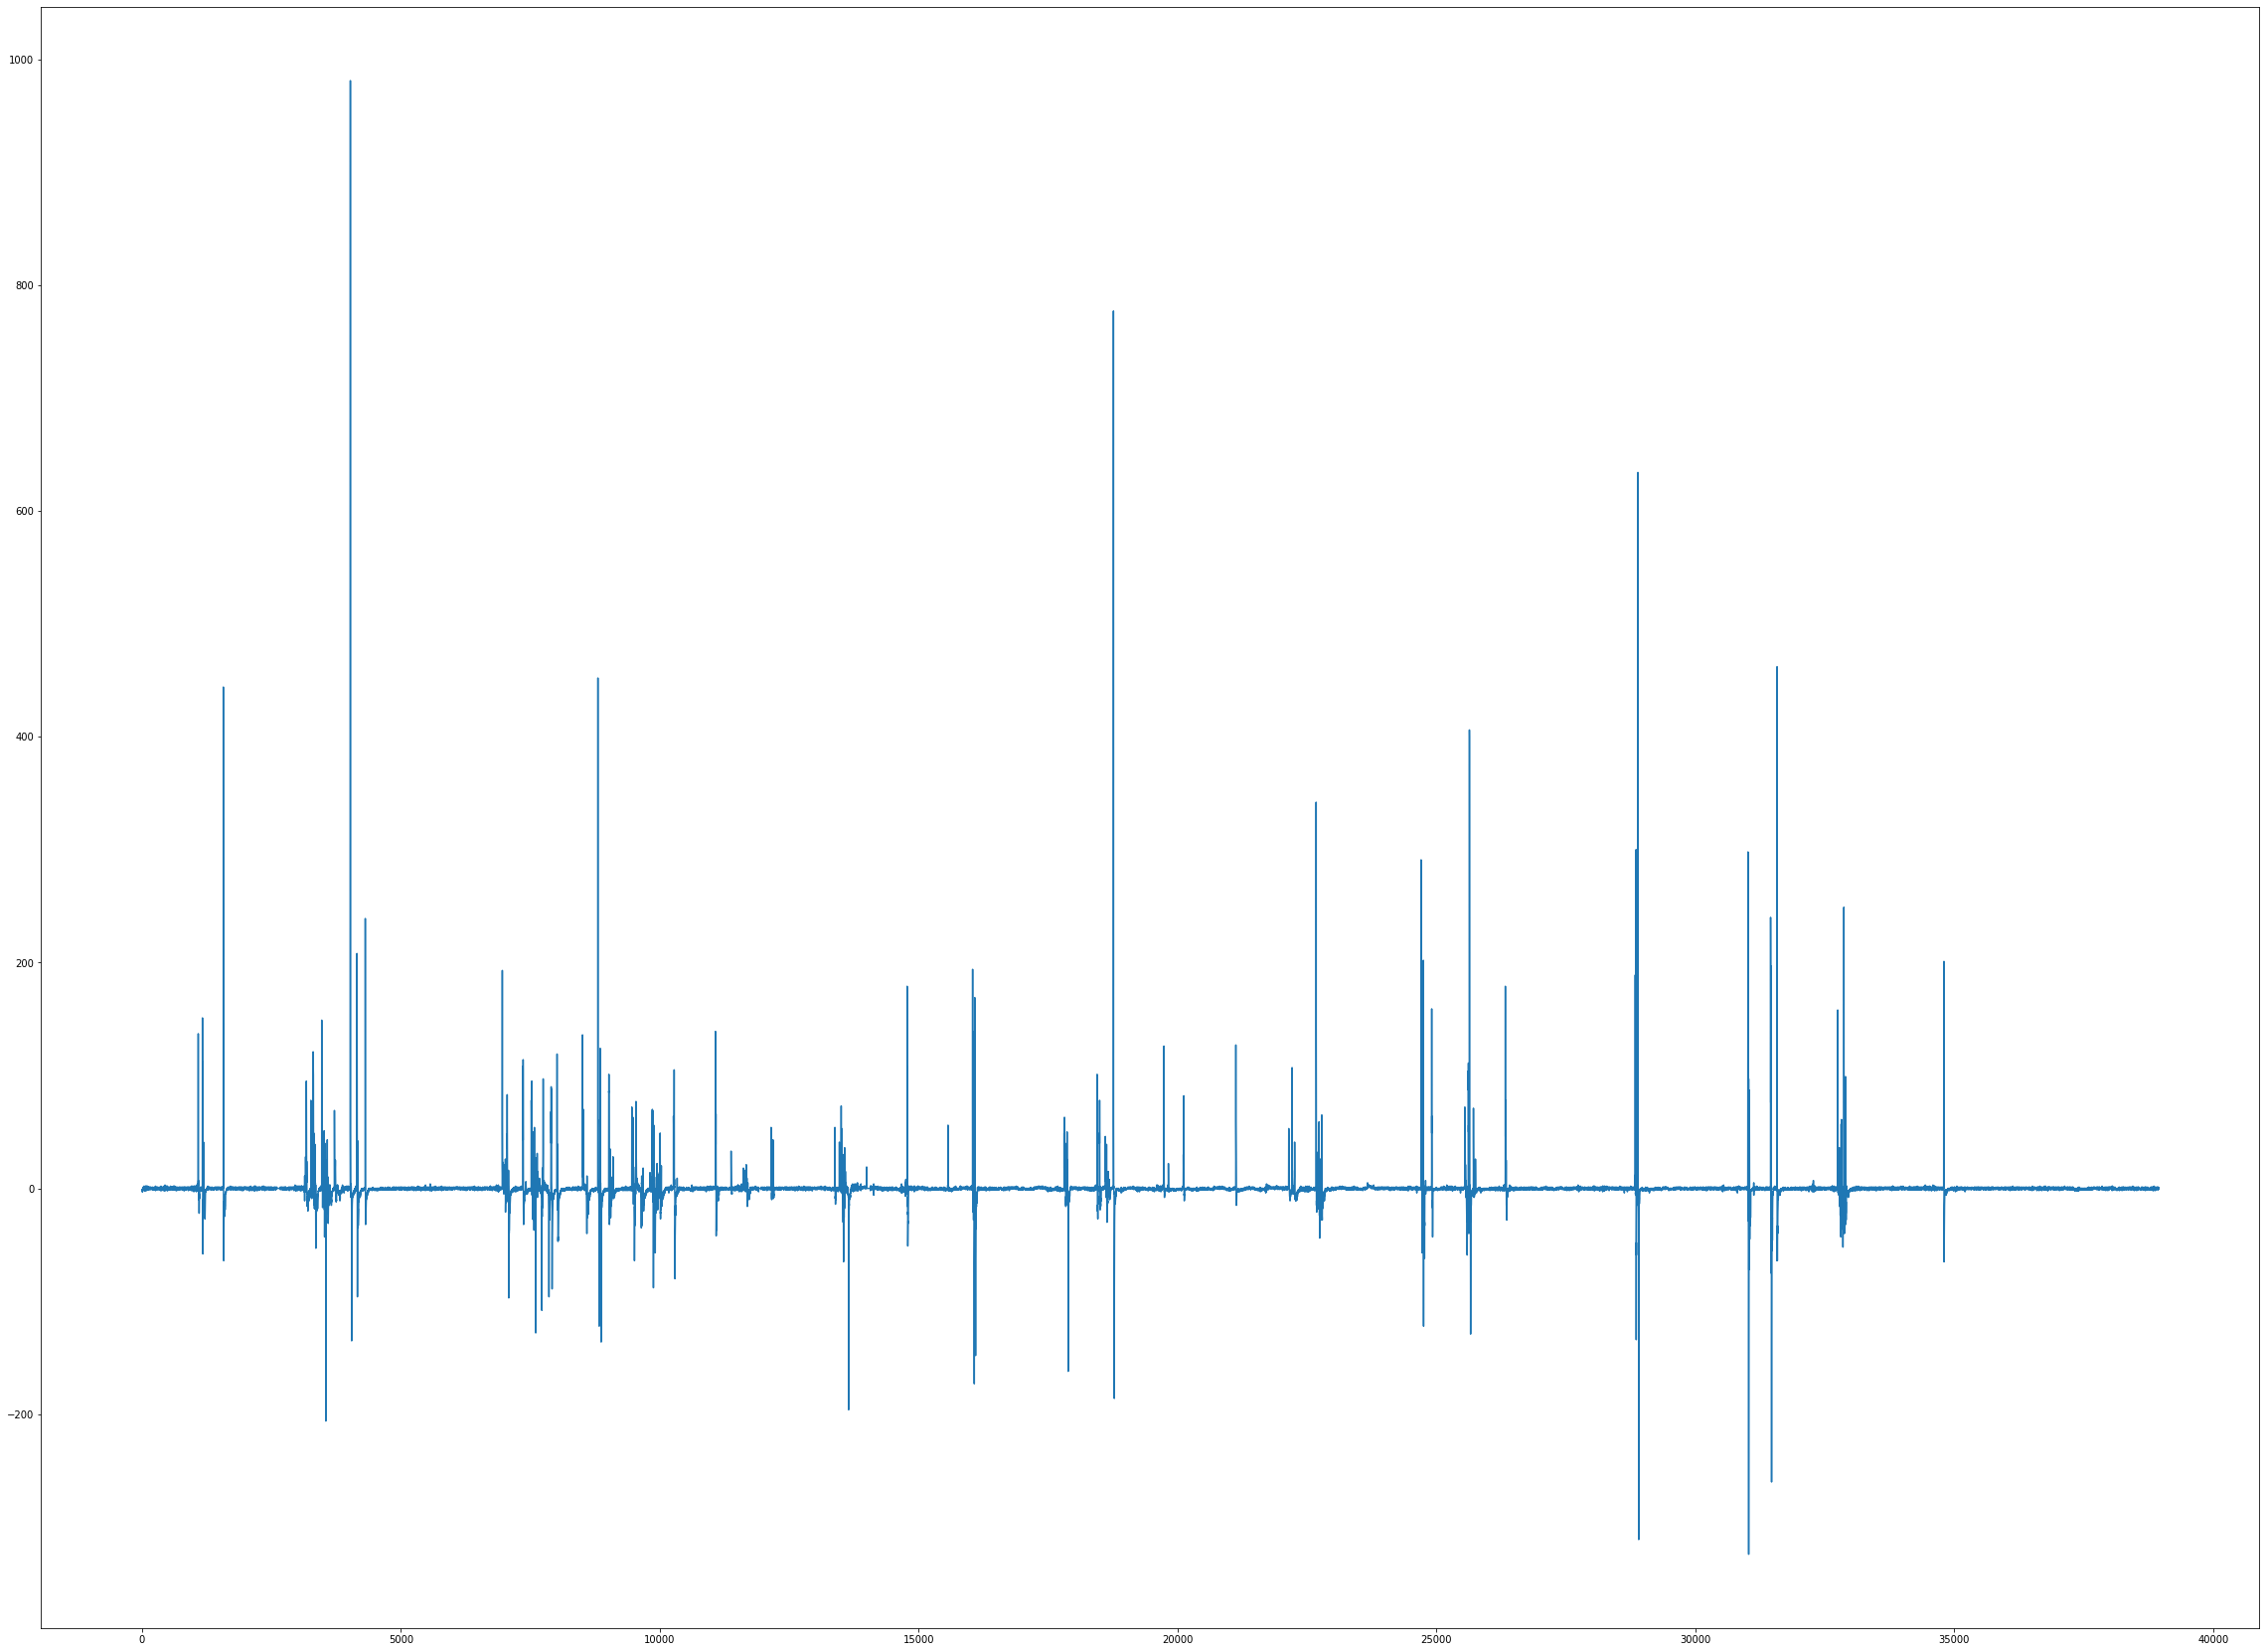

In [119]:
plt.figure(figsize=(40, 30))
plt.plot(water_level_changeA)

In [123]:
water_level_changeA[13990:14100]

array([ 1.,  1.,  0.,  1.,  1., 19., 10.,  5.,  3.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,
       -2., -1.,  0., -1.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  1.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  1., -1.,  0.,
        0.,  0.,  1.,  1., -1.,  0.])

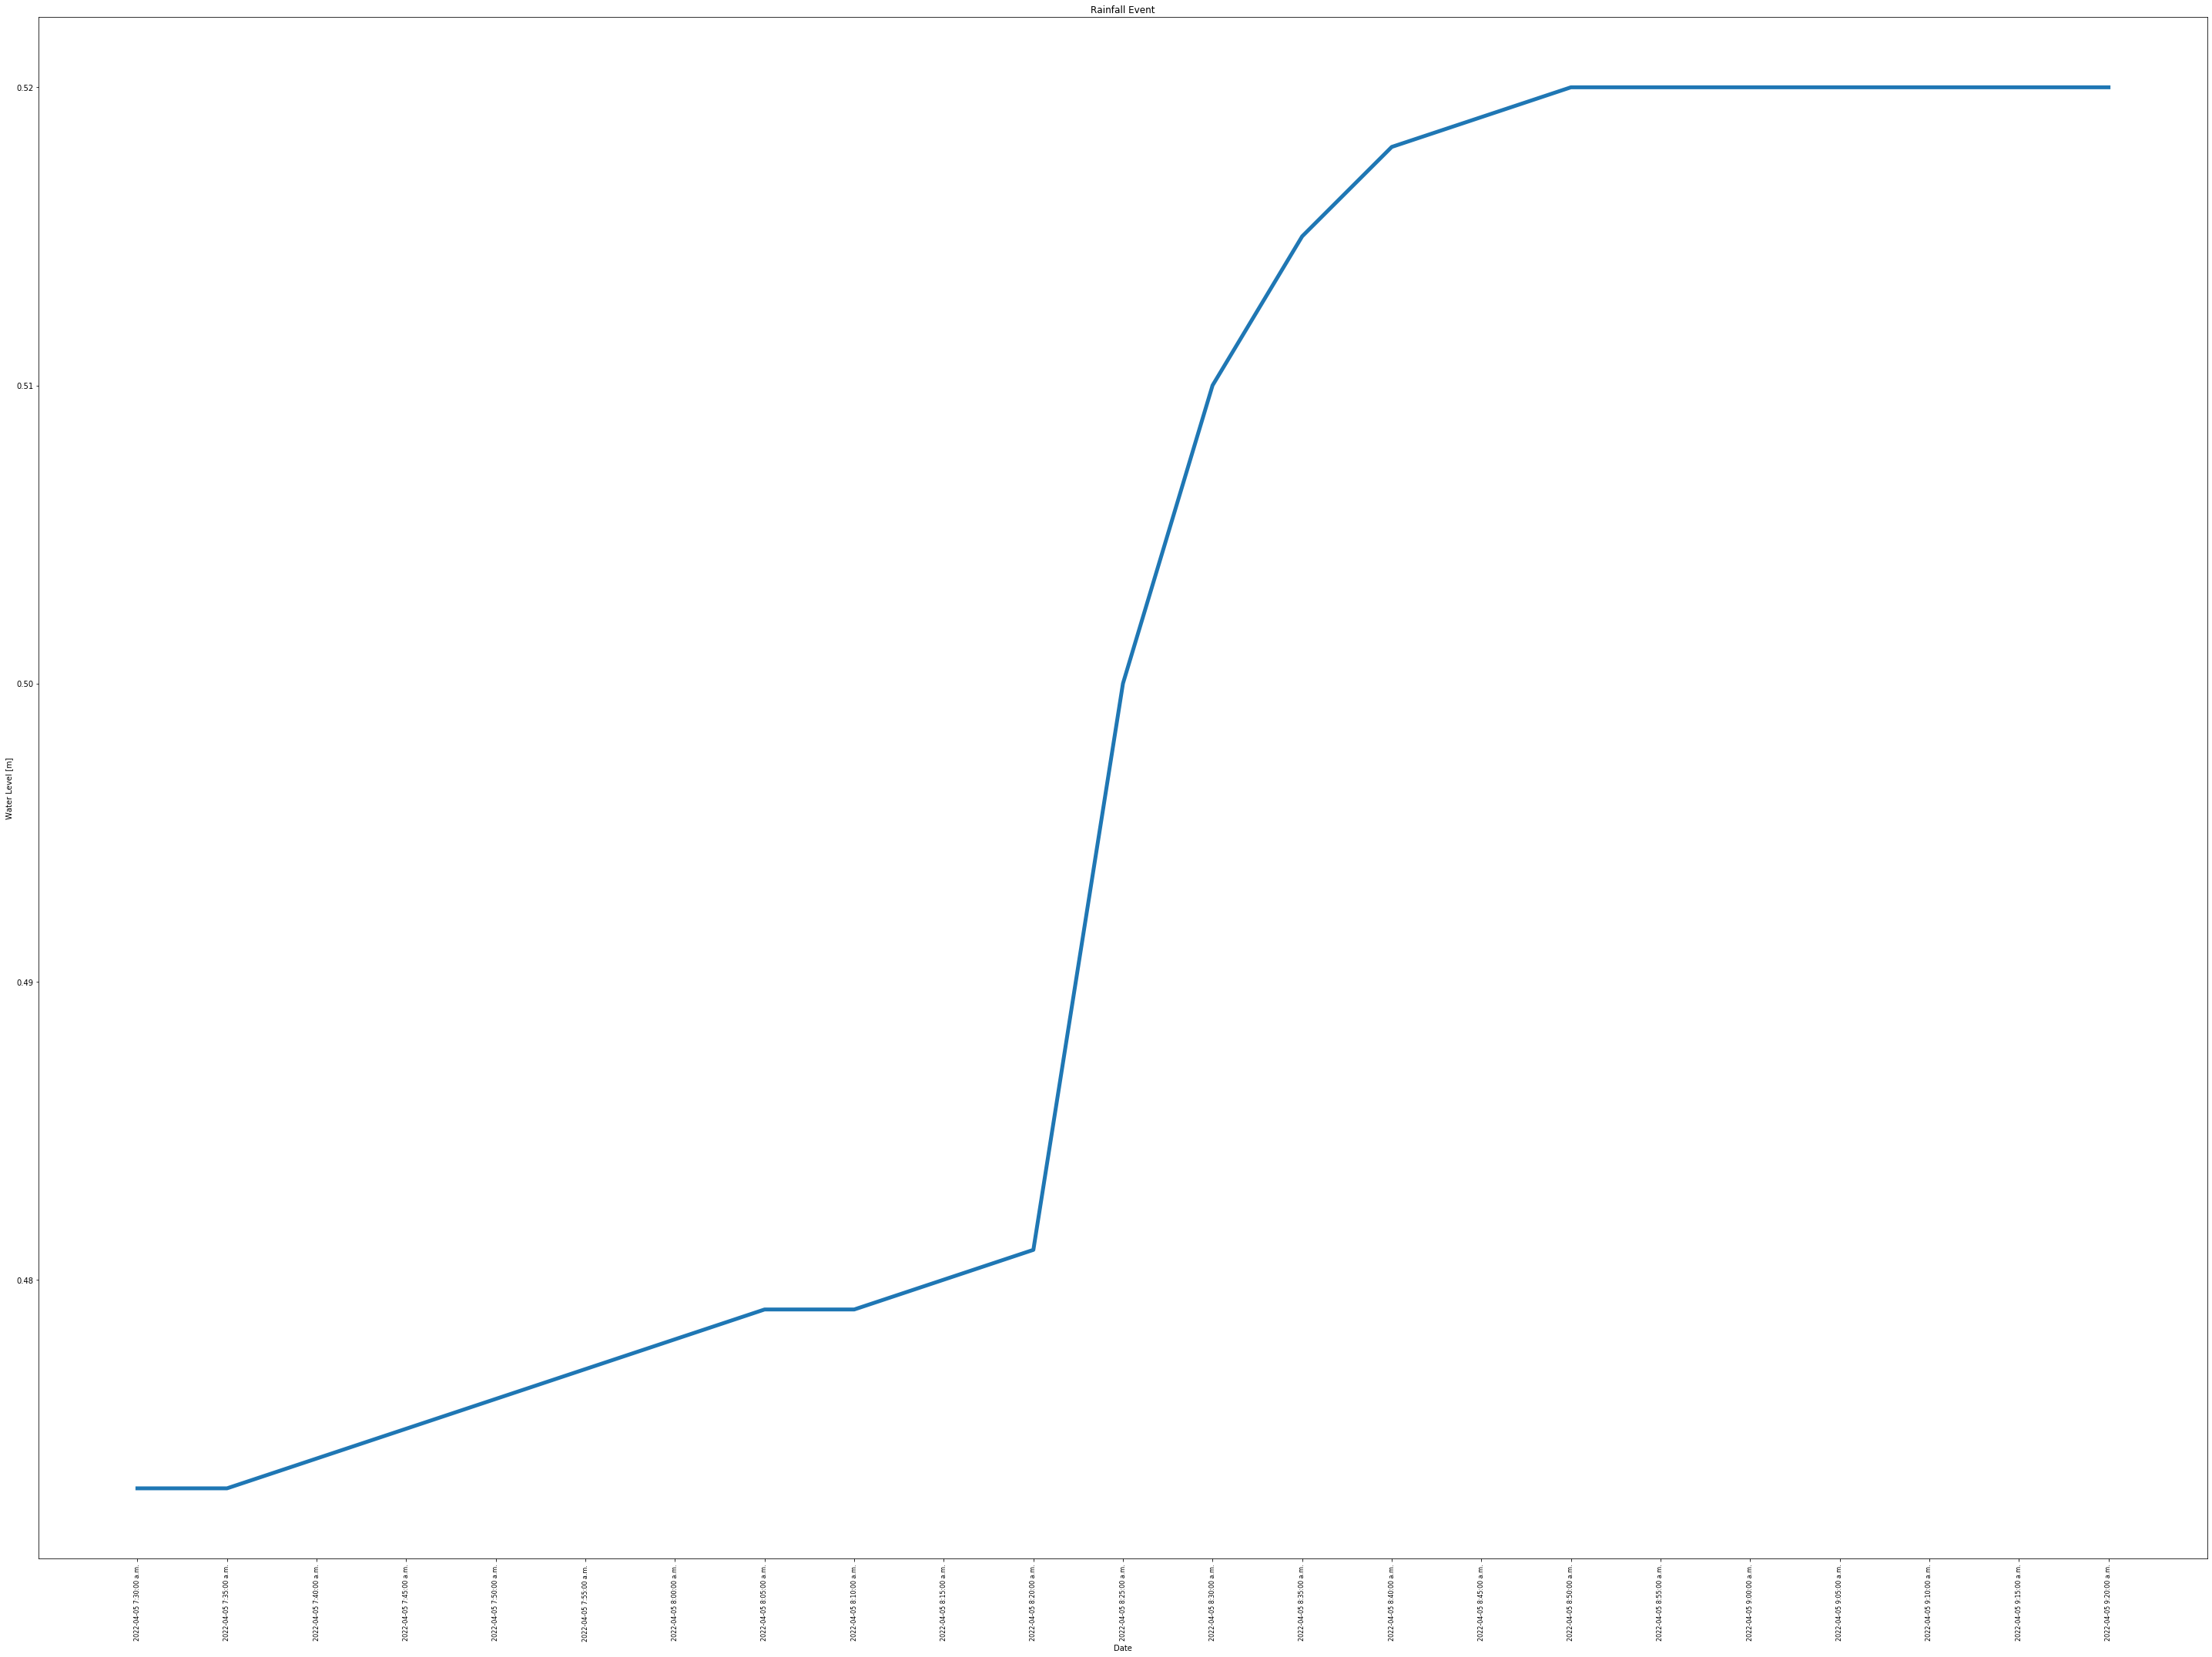

In [122]:
# Rainfall event
buffer=10
index=14
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
#plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()

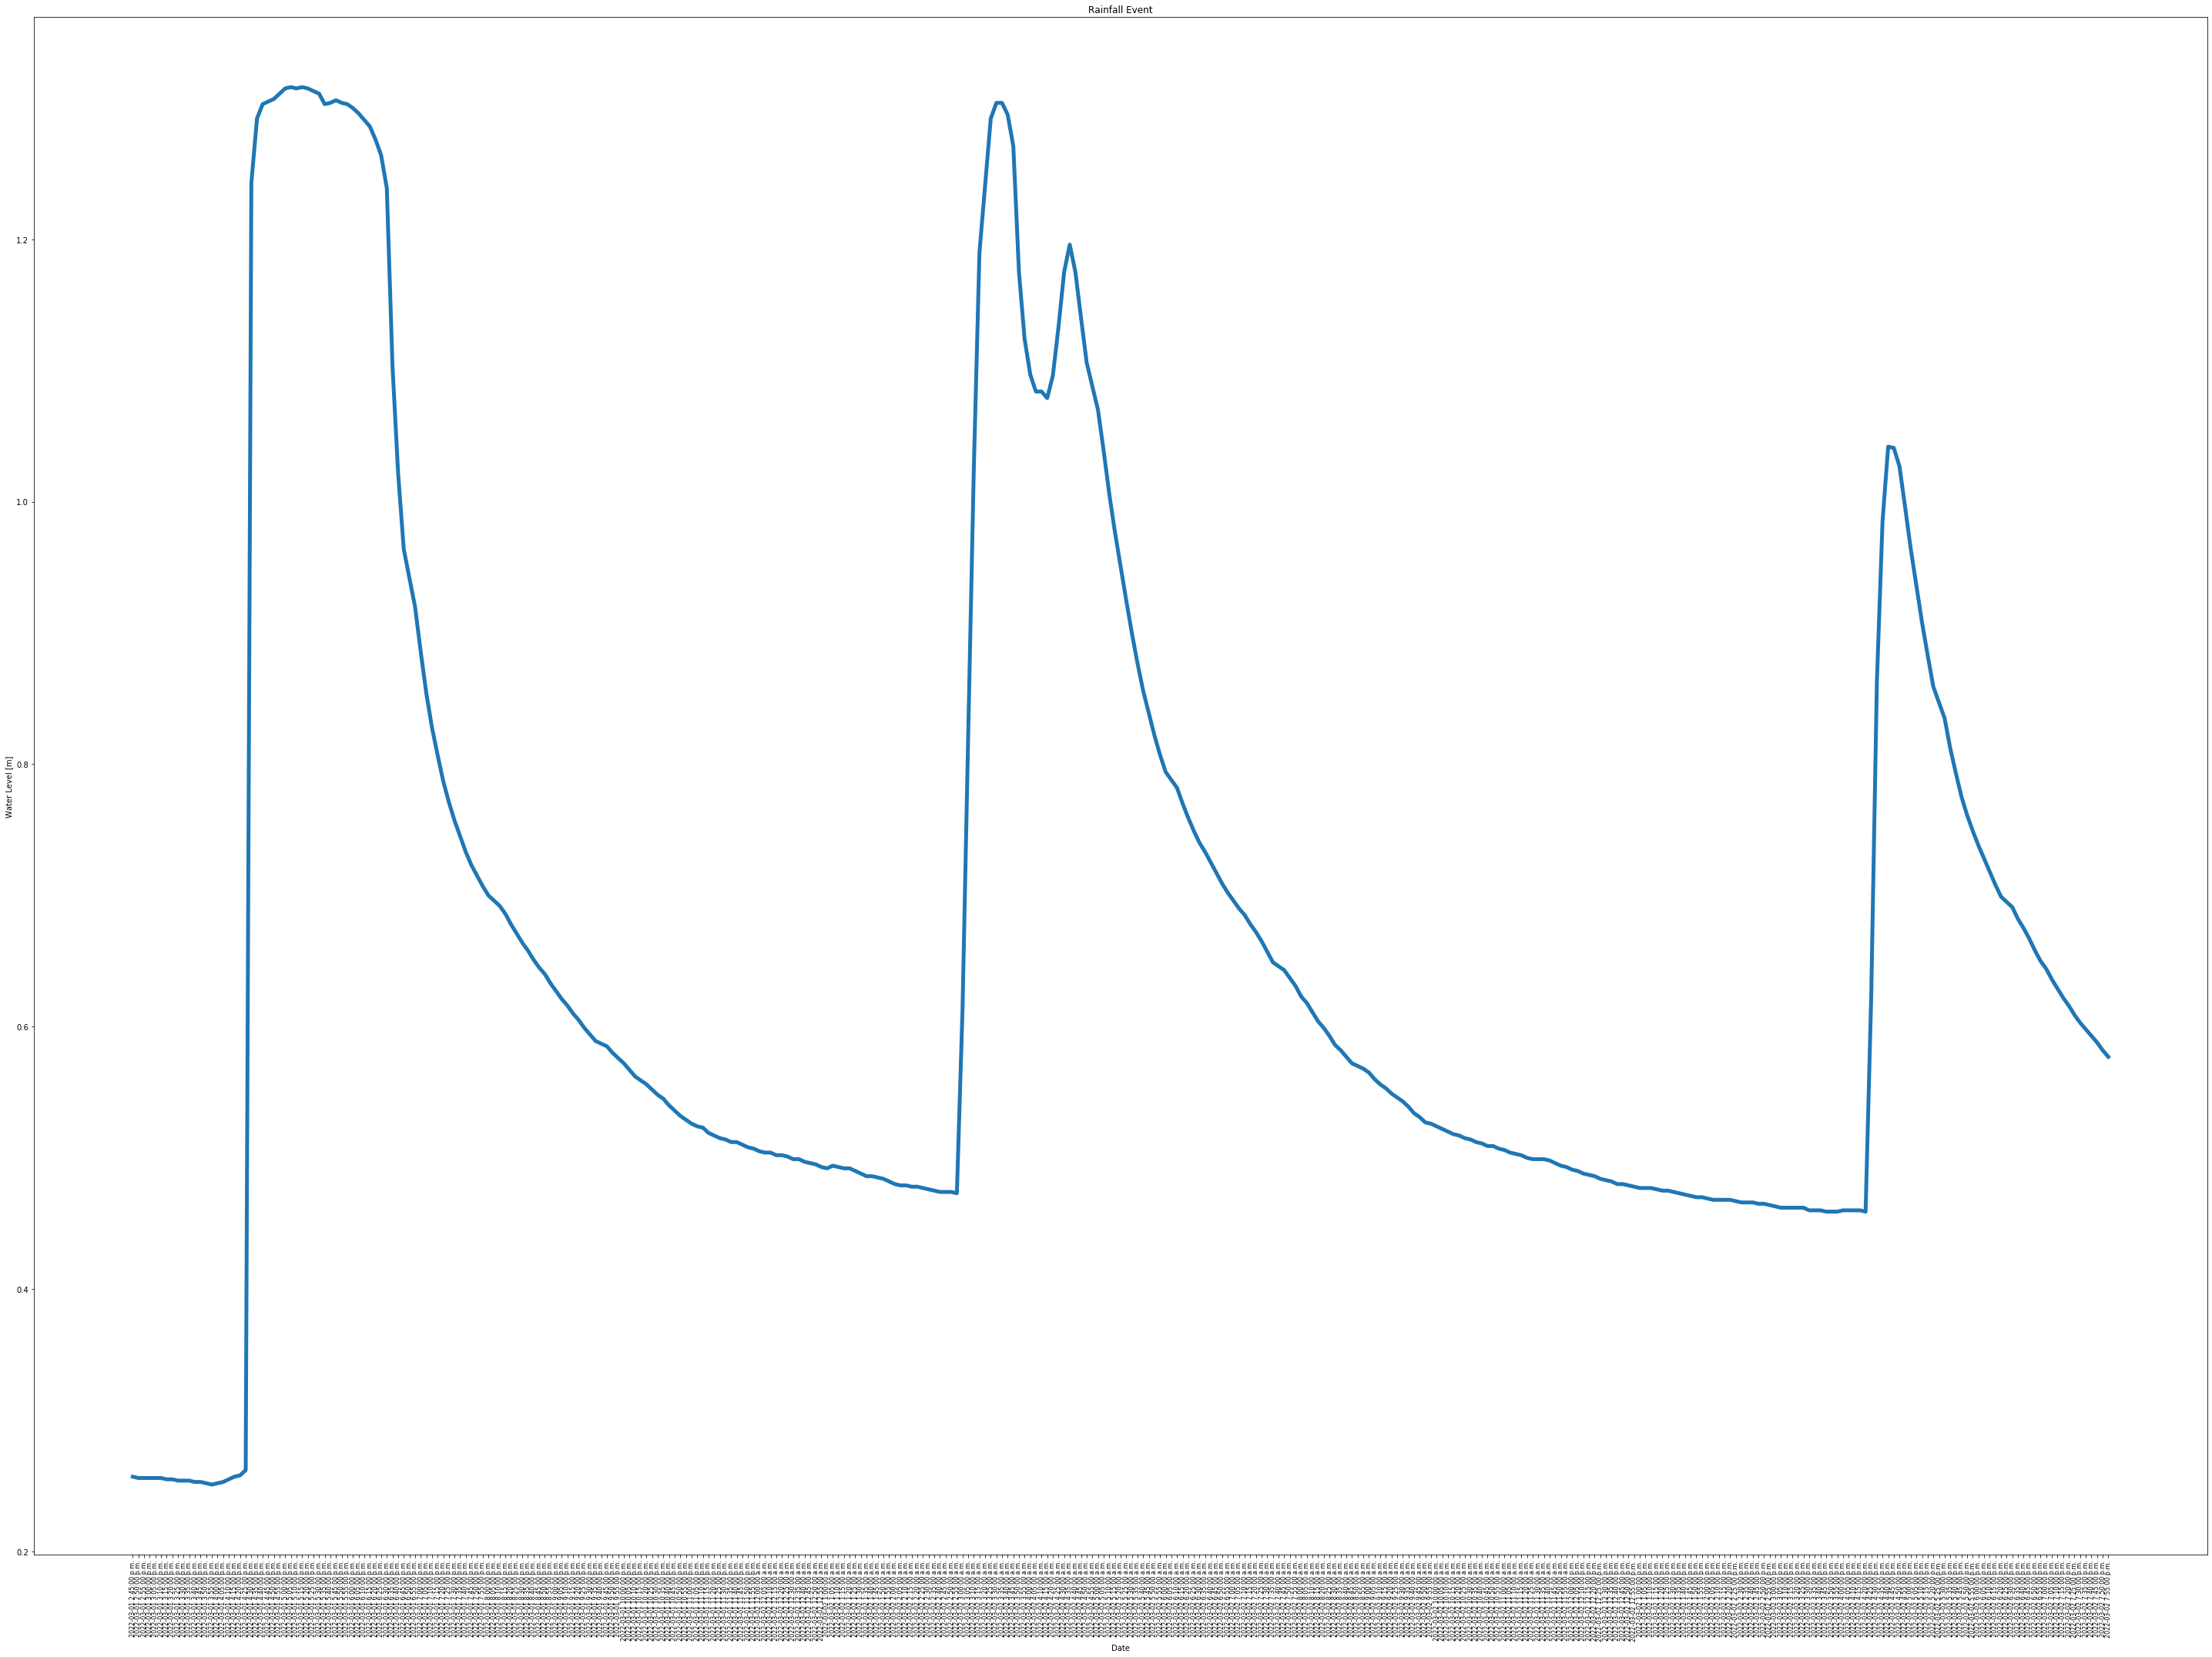

In [107]:
# Rainfall event
buffer=20
index=3
X=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer]["Timestamp"])
Y=list(sADF.loc[rf_eventA["Rainfall_start_index"][index]-buffer:rf_eventA["Rainfall_end_index"][index]+buffer][" Water Level [m]"])

plt.figure(figsize=(40, 30))
plt.plot(X,Y,linewidth=5)
#plt.axhline(y=tolA, color='r', linestyle='-')
plt.title('Rainfall Event')
plt.xlabel('Date')
plt.ylabel('Water Level [m]')
plt.tick_params(axis='x',labelsize=8,rotation=90)
plt.tight_layout()
plt.show()